**IMPORT PYTHON PACKAGES**   

In [16]:
import flopy

import numpy as np

import os
import os.path
import sys

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches

import warnings
import pickle
import time

import csv
import breanna_subfunctions as subfxn

warnings.simplefilter(action='ignore', category=UserWarning)                                          # suppress warnings related to older versions of some packages that we need to use to run flopy
warnings.simplefilter(action='ignore', category=RuntimeWarning)                                       # suppress warnings related to older versions of some packages that we need to use to run flopy


**&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&**


**USER-DEFINED SETTINGS**
   (Make changes here)


**&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&**


In [17]:
start = time.time()

stakeholder='env'                                                                                      # choose from ag/town/env
stage='combine'                                                                                        # choose from random/reseed/combined/afterdata
prefix = stakeholder + '_' + stage + '_'      #generates filename prefix
    
displaycolumn=40                                                                                       # column for head and drawdown analysis
displayrow=30                                                                                         # row for head and drawdown analysis
strdisplaycolumn=35                                                                                   # column for streamflow analysis

minmismatch=0.05                                                                                      # don't consider mismatches that are less than this value - avoids unrealistically high likelihoods
scenario = ('ntna','ytna','ytya')

# define criteria to meet to qualify as behavioral ... if a model PASSES this test it is behavioral
in_time       = [1,1,1]     # 0=ntna, 1=ytna, 2=ytya ... enter a number for each criterion applied
in_basis      = [0,0,1]     # see list below
in_comparison = [1,0,1]     # 0 = greater than, 1 = less than
in_limit      = [2000,10,3] # value defining behavioral response
in_column     = [15,15,15]  # column of observation point for basis 2 or 3  - must have a value for every criterion, even if not used
in_row        = [15,15,15]  # row of observation point for basis 2 or 3 - must have a value for every criterion, even if not used

# pack the above behavioral criteria into a dictionary for ease of recall
behavioral_criteria = [in_time, in_basis, in_comparison, in_limit, in_column, in_row]
B_keys              = ['time' , 'basis' , 'comparison' , 'limit' , 'column' , 'row']
dict_B_criteria     = dict(zip(B_keys, behavioral_criteria))

subfxn.comparison_directory()
np.save(prefix + 'behavioral_criteria',behavioral_criteria) #save behavioral criteria to a file
subfxn.output_directory()

define_mocs = True                                                                                    # define criteria to meet to qualify as an MOC ... if a model PASSES this test it is a model of concern (MOC)
if stakeholder=='town':
    moc_time_sequence =       [2]                                                                       # 0=ntna, 1=ytna, 2=ytya ... enter a number for each criterion applied
    moc_basis_sequence =      [4]                                                                       # see list below
    moc_comparison_sequence = [0]                                                                       # 0 = greater than, 1 = less than
    moc_limit_sequence =      [0.5]                                                                   # value defining behavioral response
    moc_column_sequence =     [37]                                                                     # column of observation point for basis 2 or 3  - must have a value for every criterion, even if not used
    moc_row_sequence =        [20]                                                                     # row of observation point for basis 2 or 3 - must have a value for every criterion, even if not used
elif stakeholder=='ag':
    moc_time_sequence =       [2]                                                                       # 0=ntna, 1=ytna, 2=ytya ... enter a number for each criterion applied
    moc_basis_sequence =      [3]                                                                       # see list below
    moc_comparison_sequence = [1]                                                                       # 0 = greater than, 1 = less than
    moc_limit_sequence =      [68]                                                                   # value defining behavioral response
    moc_column_sequence =     [13]                                                                     # column of observation point for basis 2 or 3  - must have a value for every criterion, even if not used
    moc_row_sequence =        [11]                                                                     # row of observation point for basis 2 or 3 - must have a value for every criterion, even if not used
elif stakeholder=='env':
    moc_time_sequence =       [2]                                                                       # 0=ntna, 1=ytna, 2=ytya ... enter a number for each criterion applied
    moc_basis_sequence =      [2]                                                                       # see list below
    moc_comparison_sequence = [1]                                                                       # 0 = greater than, 1 = less than
    moc_limit_sequence =      [50]                                                                   # value defining behavioral response
    moc_column_sequence =     [38]                                                                     # column of observation point for basis 2 or 3  - must have a value for every criterion, even if not used
    moc_row_sequence =        [25]                                                                     # row of observation point for basis 2 or 3 - must have a value for every criterion, even if not used
    
# we should add the ability to have an MOC criterion in other than layer 1!!
# add criterion for flow reduction

#   BASES FOR DETERMINATION OF BEHAVIORAL MODEL
#       0 = max streamflow along stream
#       1 = min groundwater depth over first layer
#       2 = streamflow at specified location
#       3 = head at specified location
#       4 = drawdown at specified location

# use empty brackets if no data available, each value must contain the same number of inputs, separate multiple data points by commas
moc_criteria = [moc_time_sequence, moc_basis_sequence, moc_comparison_sequence, moc_limit_sequence, moc_column_sequence, moc_row_sequence]
subfxn.comparison_directory()
np.save(prefix + 'moc_criteria',moc_criteria) #save moc criteria to a file
subfxn.output_directory()

'''# True to read in the observations from truth_heads_ss_ytna.npy and truth_flows_ss_ytna.npy
useTrueData_flag = True                                                                                 
if useTrueData_flag == True:
    subfxn.output_directory()
    trueheads_ss_ytna=np.load('truth_heads_ss_ytna.npy')[0][:][:]
    trueflows_ss_ytna=np.load('truth_strflow_ss_ytna.npy')[:]

# set to true to use available data to calculate likelihoods, false to set models as equally likely
usedata = useTrueData_flag                                                                                        
data_time_sequence = [1,1]                                                                            # 0 = ntna, 1 = ytna, 2 = ytya
data_basis_sequence =[1,1]                                                                            # identify head or flow observation
data_layer_sequence = [0,0]                                                                           # layer of head observation - enter zero for flow
data_column_sequence = [35,20]                                                                         # column of head or flow observation
data_row_sequence = [20,30]                                                                           # row of head or flow observation
data_value_sequence = np.zeros((np.shape(data_row_sequence)))
for ii in np.arange(np.shape(data_row_sequence)[0]):                                                              
    if data_basis_sequence[ii]==1:
        data_value_sequence[ii]=trueheads_ss_ytna[data_row_sequence[ii],data_column_sequence[ii]]     # Retrieve head data in top layer from the 'truth' model
    elif data_basis_sequence[ii]==0:
        data_value_sequence[ii]=trueflows_ss_ytna[data_column_sequence[ii]][1]                        # Retrieve flow data in stream from the 'truth' model
        
#   TYPES OF OBSERVATION DATA CONSIDERED
#       0 = streamflow at specified location
#       1 = head at specified location

if useTrueData_flag == True:
    num_data=np.shape(data_time_sequence)[0]
else:
    num_data=0

# True to eliminate low Likelihood models from the ensemble - for now, always set to true, but set number to eliminate to zero to turn off
eliminate_lowL_models=True
lowLcut_percent=10  # remove this percent of models with the lowest L values
lowLcut_number=0    # don't remove any more than this number of models, no matter how low their L value, despite above limit
lowLlimit=0.05      # don't remove models with an L higher than this, despite above limits
lowLecho=True       # True to list the low L models, False to suppress (in case you have a lot!)

#Export files needed for multi-stakeholder comparisons:
#To import, use np.load()
comparison_directory()               #change directory to current stakeholder and stage
np.save(prefix + 'data_layer', data_layer_sequence)
np.save(prefix + 'data_row', data_row_sequence)
np.save(prefix + 'data_column', data_column_sequence)
output_directory()'''

# use the following to control which analyses are completed - may be useful when running partial analyses for many models
run_sections=3

# 0 = through identifying behavioral models and calculating model likelihoods
# 1 = identify models of concern
# 2 - calculate discriminatory index
# 3 - particle capture


Carried over variables

    in_time_sequence, in_basis_sequence, in_layer_sequence, in_column_sequence, in_value_sequence
    moc_time_sequence, moc_basis_sequence, moc_layer_sequence, moc_column_sequence, moc_value_sequence
    data_time_sequence, data_basis_sequence, data_layer_sequence, data_column_sequence, data_value_sequence
  
    define_mocs, usedata, eliminate_lowL_models, 
    displaycolumn, displayrow, strdisplaycolumn
    minmismatch
    lowLcut_percent, lowLcut_number, lowLlimit, lowLecho 
  
    num_data
  
    trueheads_ss_ytna, trueflows_ss_ytna

**READ IN ALL MODELS IN OUTPUT DIRECTORY FOR ANALYSIS**



In [18]:
files = os.listdir(os.curdir)                                                                         # all files in output directory
runnumbers, t_runnumbers = subfxn.readInModels()
Nmodels = len(runnumbers)

Carried over variables

    runnumbers, t_runnumbers

**BASIC INPUT FOR PLOT FEATURES**


In [19]:
run_params, [nrow,ncol,delr,delc,Lx,Ly,nlay,ztop,crop,fNWc,well1,well2,
            recharge_ratio,return_loc,rNWc, K_horiz, Kzratio_low, Sy, 
            R1, ET1, ETratio_riparian, Kratio_stream] = subfxn.run_parvals(runnumbers)

# assume well and recharge and return flow locations same for all runs and that the following are unchanged--
# eventually, include these in the parvals file

nreach = 48+1                                       # number of reaches (# of cells in stream + 1 canal reach) 
strrow=25                                           # row in which stream resides
reaches = np.arange(ncol-1)                         # for plotting flow along stream
str_rows = strrow*np.ones((nreach),dtype=np.int32)  # integer array of row #s for each stream reach 
str_cols = np.arange(1,nreach+1)                    # integer array of col #s for each stream reach

Carried over variables

    run_params
    nreach, strrow, reaches, str_rows, str_cols

**IMPORT MODEL RESULTS**


In [20]:
[allheads_ss, allbudgets_ss, alldwt_ss, allflows_ss,
 allleaks_ss, maxdwt_ss, allepts_ss_ntna, allepts_ss_ytna,
 allepts_ss_ytya, dd] = subfxn.modelResults(runnumbers, ztop, return_loc)

Carried over variables

    allheads_ss, allbudgets_ss, alldwt_ss, allflows_ss, allleaks_ss, maxdwt_ss, allepts_ss, dd

**COMPILE DATA TO ASSESS (NON)BEHAVIORAL MODELS**


In [21]:
num_criteria=0

cullmodels, cullmodels_counter = subfxn.nonbehavioralModels(runnumbers, allheads_ss, maxdwt_ss, allflows_ss, dd)    

Assessing (non)behavioral criteria
Assessing criterion 0
Assessing criterion 1
Assessing criterion 2


Carried over variables

    cullmodels, cullmodels_counter


**COMPILE DATA TO ASSESS MODEL LIKELIHOODS**


In [22]:
# Use truth model data to estimate likelihood of models from the ensemble
useTrueData_flag = True     # If TRUE, read in the head/flow observations from truth model
                            # If FALSE, all models default to equally likely

# set the comparison criteria for evaluating model likelihood
data_time   = [1,1]     # 0 = ntna, 1 = ytna, 2 = ytya
data_basis  = [1,1]     # identify (1) head or (0) flow observation
data_layer  = [0,0]     # layer of head observation - enter zero for flow
data_column = [35,20]   # column of head or flow observation
data_row    = [20,30]   # row of head or flow observation

# pack the above criteria into a dictionary for ease of recall
likelihood_criteria = [data_time, data_basis, data_layer, data_column, data_row]
L_keys              = ['time'   , 'basis'   , 'layer'   , 'column'   , 'row']
dict_L_criteria     = dict(zip(L_keys, likelihood_criteria))

# True to eliminate low Likelihood models from the ensemble - for now, always set to true, but set number to eliminate to zero to turn off
eliminate_lowL_models=True
lowLcut_percent=10          # remove this percent of models with the lowest L values
lowLcut_number=0            # don't remove any more than this number of models, no matter how low their L value, despite above limit
lowLlimit=0.05              # don't remove models with an L higher than this, despite above limits
lowLecho=True               # True to list the low L models, False to suppress (in case you have a lot!)

# Retrieve data from truth model files when flag is set to true
if useTrueData_flag == True:
    truth_value, num_L_criteria = subfxn.useTrueData(dict_L_criteria)

    #Export files needed for multi-stakeholder comparisons:
    subfxn.comparison_directory()               #change directory to current stakeholder and stage
    np.save(prefix + 'data_layer' , dict_L_criteria['layer'])
    np.save(prefix + 'data_row'   , dict_L_criteria['row'])
    np.save(prefix + 'data_column', dict_L_criteria['column'])
    subfxn.output_directory()

else:
    num_L_criteria = 0

if useTrueData_flag == True:
    startdata, cullmodels, cullmodels_counter = subfxn.compileLikelihoodData(cullmodels, cullmodels_counter,
                                                                            dict_L_criteria, num_L_criteria,
                                                                            allflows_ss, allheads_ss,
                                                                            scenario, Nmodels, prefix)

Carried over variables

    startdata
    cullmodels, cullmodels_counter
    


In [23]:
print(cullmodels_counter)
print(startdata)
print(cullmodels[0][0:10])

2
3
[180.8971405  180.8971405   -1.47740631  73.26460266  74.32702637
   0.           0.           0.           0.           0.        ]


**CALCULATE MODEL LIKELIHOODS - SET NONBEHAVIORAL TO LOW L**


In [24]:
rmse, cullmodels_counter, cullmodels, L, sorted_L_behavioral = subfxn.calculateModelLikelihood(dict_B_criteria, truth_value,
                                                                                               cullmodels, cullmodels_counter, num_L_criteria,
                                                                                               startdata, Nmodels, useTrueData_flag)

Carried over variables

    rmse, L, sorted_L_behavioral
    cullmodels, cullmodels_counter


** DEFINE (NON)BEHAVIORAL MODELS AND COMPILE STATISTICS **


In [25]:
# Function returns (non)behavioral model indices and names as list of lists (see below)
# [behavioral_idx, behavioral_models, nonbehavioral_idx, nonbehavioral_models]
modelBehavior = subfxn.modelBehavior(runnumbers, rmse)

In [30]:
modelBehavior[2]

[5, 16, 21, 37, 78, 80, 84, 89, 90, 91, 97]

In [26]:
b_meanid, b_varid, nonb_meanid, nonb_varid = subfxn.behaviorStats (modelBehavior, runnumbers, dict_B_criteria, cullmodels, Nmodels)

# if 'in_time_sequence' in locals():
#     num_criteria=np.shape(in_time_sequence)[0]                                                    # determine number of criteria to that have been applied

# if num_criteria>0:
#     for ii in np.arange(num_criteria):                                                            # loop over bases for discrimination of models of concern or (non)behavioral models
#         in_comparison=in_comparison_sequence[ii]
#         sorted_in_metric=np.sort(cullmodels[:,ii])[::-1]                                          # sort metric in decreasing order for plotting

#         # save results to plot later
#         plottype=0                                                                                # distinguish behavioral (0) and MOC (1) plots
#         holdplottype.append(plottype)
#         holdplotx.append(np.arange(np.shape(sorted_in_metric)[0]))                                # store ordinal numbers from 0 to number of models
#         holdploty.append(sorted_in_metric)                                                        # hold sorted values of the metric used for assessment, high to low
#         if in_comparison==0:                                                                      # greater than indicates behavioral
#             holdleftlimit.append(np.shape(behavioral_ids)[0])                                     # limits of behavioral models for sorted plot
#             holdrightlimit.append(np.shape(sorted_in_metric)[0])
#         elif in_comparison==1:                                                                    # less than indicates behavioral
#             holdleftlimit.append(0)
#             holdrightlimit.append(np.shape(sorted_in_metric)[0]-np.shape(behavioral_ids)[0])
   
#     if np.shape(nonbehavioral_ids)[0]>0:                                                          # assess prevalence of each parameter for in and not-in groups
#         tempvar=[]
#         b_meanid=np.zeros(7)
#         b_varid=np.zeros(7)
#         for i in np.arange(9,16):                                                                 # count over parameters that are varied in models that exceed max flow
#             tempvar=np.zeros(len(behavioral_ids_index))                                           # establish array with size equal to number of behavioral models
#             counter=-1
#             for j in (behavioral_ids_index):                                                      # count over behavioral models
#                 counter=counter+1
#                 tempvar[counter]= int(runnumbers[j][i])                                           # store digit from model number
#             b_meanid[i-9]=np.mean(tempvar)                                                        # find mean of each digit
#             b_varid[i-9]=np.std(tempvar)                                                          # find standard deviation over each digit
#         tempvar=[]
#         nonb_meanid=np.zeros(7)
#         nonb_varid=np.zeros(7)
#         for i in np.arange(9,16):                                                                 # count over parameters that are varied in models that exceed max flow
#             tempvar=np.zeros(len(nonbehavioral_ids_index))
#             counter=-1
#             for j in (nonbehavioral_ids_index):                                                   # count over models that exceed max flow
#                 counter=counter+1
#                 tempvar[counter]= int(runnumbers[counter][i])                                     # store digit from model number
#             nonb_meanid[i-9]=np.mean(tempvar)                                                     # find mean of each digit
#             nonb_varid[i-9]=np.std(tempvar)                                                       # find standard deviation over each digit
#         nonb_meanid=np.round(nonb_meanid*1000)/1000                                               # truncate for better presentation in table
#         nonb_varid=np.round(nonb_varid*1000)/1000                
#     else:
#         print('All models are behavioral')

#     del num_criteria                                                                              # clear temporary variables
#     del tempvar
#     del counter
#     del plottype
#     del sorted_in_metric

# else:
#     print('No (non)behavioral criteria listed')
    


In [31]:
modelBehavior[3]

['m001001330202214',
 'm001001330402000',
 'm001001331014241',
 'm001001331334210',
 'm001001334011004',
 'm001001334034344',
 'm001001334110344',
 'm001001334233144',
 'm001001334302344',
 'm001001334320024',
 'm001001334420024']

In [28]:
nonb_meanid

array([2.727, 2.   , 1.455, 2.   , 1.455, 2.364, 3.   ])

In [29]:
nonb_varid

array([2.727, 2.   , 1.455, 2.   , 1.455, 2.364, 3.   ])

Carried over variables

    behavioral_ids, nonbehavioral_ids, behavioral_ids_index, nonbehavioral_ids_index
    holdplotx, holdploty, holdleftlimit, holdrightlimit, holdplottype
    b_meanid, b_varid, nonb_meanid, nonb_varid


** REMOVE LOW LIKELIHOOD MODELS AND RECALCULATE LIKELIHOODS **

In [13]:
sorted_L=np.sort(L)[::-1]
if eliminate_lowL_models==True:
    Lcut_ids=np.argsort(L)                                                                        # sort model indices by L, increasing
    Lcut_vals=np.sort(L)
    numtoremove=int(np.shape(L)[0]*(lowLcut_percent)/100)+np.shape(nonbehavioral_ids)[0]          # find number of models represented by % to remove
    checkLlimit=np.sum(Lcut_vals<lowLlimit)                                                       # don't cut models with L above lowLlimit
    numtoremove=min(checkLlimit,numtoremove)
    numtoremove=min(numtoremove,lowLcut_number)                                                   # don't allow number to remove to pass number limit
    Lcut_ids=Lcut_ids[0:numtoremove]     
    rmse[Lcut_ids]=1.23456e9
    Ltemp=1/rmse                                                                                  # invert rmse as first step to calculating L
    L=Ltemp/np.sum(Ltemp)

    cullmodels_counter=cullmodels_counter+1
    cullmodels[:,cullmodels_counter]=L                                                            # store data used to check (non)behavioral status

# UNCOMMENT THE FOLLOWING TO DELETE RESULTS RATHER THAN JUST SETTING TO VERY LOW L
#     excludemodels1=rmse==1.23456e9
#     excludemodels1=1*excludemodels
#     excludemodels2=(np.arange(np.shape(runnumbers)[0]))
#     excludemodels=excludemodels2[excludemodels1==1]
#     for i in np.arange(np.shape(excludemodels)[0]):                                             # delete non-behavioral models
#         del runnumbers[excludemodels[i]]
#         allheads_ss_ntna = np.delete(allheads_ss_ntna, excludemodels[i],axis=0)                 # remove calculation rows for excluded models
#         allheads_ss_ytna = np.delete(allheads_ss_ytna, excludemodels[i],axis=0)
#         allheads_ss_ytya = np.delete(allheads_ss_ytya, excludemodels[i],axis=0)
#         allflows_ss_ntna = np.delete(allflows_ss_ntna, excludemodels[i],axis=0)
#         allflows_ss_ytna = np.delete(allflows_ss_ytna, excludemodels[i],axis=0)
#         allflows_ss_ytya = np.delete(allflows_ss_ytya, excludemodels[i],axis=0)
#         allleaks_ss_ntna = np.delete(allleaks_ss_ntna, excludemodels[i],axis=0)
#         allleaks_ss_ytna = np.delete(allleaks_ss_ytna, excludemodels[i],axis=0)
#         allleaks_ss_ytya = np.delete(allleaks_ss_ytya, excludemodels[i],axis=0)
#         allepts_ss_ntna = np.delete(allepts_ss_ntna, excludemodels[i],axis=0)            
#         dd = np.delete(dd, excludemodels[i],axis=0)     
#         run_params = np.delete(run_params, excludemodels[i],axis=0)                             # remove model names from list, too 

    del numtoremove                                                                                   # clear temporary variables
    del checkLlimit
    del Ltemp
    del Lcut_vals


Carried over variables

    Lcut_ids
    rmse, L
    cullmodels, cullmodels_counter


** IDENTIFY MODELS OF CONCERN **

In [14]:
if run_sections>0:
    if define_mocs==True:
        moc_total=np.zeros((np.shape(runnumbers)[0]))
        num_criteria=np.shape(moc_time_sequence)                                                      # determine number of criteria to apply    
        for ii in np.arange(num_criteria[0]):                                                         # loop over bases for discrimination of models of concern or (non)behavioral models
            print('Assessing model of concern criterion',ii)
            in_time=moc_time_sequence[ii]
            in_basis=moc_basis_sequence[ii]
            in_comparison=moc_comparison_sequence[ii]
            in_limit=moc_limit_sequence[ii]
            in_column=moc_column_sequence[ii]
            in_row=moc_row_sequence[ii]

            if in_basis==0:
                in_metric=np.zeros((np.shape(allflows_ss_ntna)[0]))
                if in_time==0:
                    in_metric=np.max(allflows_ss_ntna,axis=1)                                         # store maximum flow for each model for ntna case
                elif in_time==1:
                    in_metric=np.max(allflows_ss_ytna,axis=1)           
                else:
                    in_metric=np.max(allflows_ss_ytya,axis=1)           
            elif in_basis==1:
                in_metric=np.zeros((np.shape(allflows_ss_ntna)[0]))     
                if in_time==0:
                    in_metric=maxdwt_ss_ntna                                                          # store minimum flow for each model for ntna case
                elif in_time==1:
                    in_metric=maxdwt_ss_ytna                            
                else:
                    in_metric=in_metric=maxdwt_ss_ytya                  
            elif in_basis==2:
                in_metric=np.zeros((np.shape(allflows_ss_ntna)[0]))     
                if in_time==0:
                    for j in np.arange(np.shape(allflows_ss_ytna)[0]):                
                        in_metric[j]=allflows_ss_ntna[j][in_column]                                   # store flow at specified location for each model for ntna case
                elif in_time==1:
                    for j in np.arange(np.shape(allflows_ss_ytna)[0]):                
                        in_metric[j]=allflows_ss_ytna[j][in_column]    
                else:
                    for j in np.arange(np.shape(allflows_ss_ytna)[0]):                
                        in_metric[j]=allflows_ss_ytya[j][in_column]    
            elif in_basis==3:
                in_metric=np.zeros((np.shape(allheads_ss_ntna)[0]))     
                if in_time==0:
                    for j in np.arange(np.shape(allheads_ss_ytna)[0]):                
                        in_metric[j]=allheads_ss_ntna[j][in_row][in_column]                           # store head at specified location for each model for ntna case
                elif in_time==1:
                    for j in np.arange(np.shape(allheads_ss_ytna)[0]):                
                        in_metric[j]=allheads_ss_ytna[j][in_row][in_column]    
                else:
                    for j in np.arange(np.shape(allheads_ss_ytna)[0]):                
                        in_metric[j]=allheads_ss_ytya[j][in_row][in_column]    
            else:
                in_metric=np.zeros((np.shape(dd)[0]))     
                if in_time==0:
                    for j in np.arange(np.shape(dd)[0]):                
                        in_metric[j]=dd[j][in_row][in_column]                                         # store drawdown at specified location for each model for ntna case
                elif in_time==1:
                    for j in np.arange(np.shape(dd)[0]):                
                        in_metric[j]=dd[j][in_row][in_column]    
                else:
                    for j in np.arange(np.shape(allheads_ss_ytna)[0]):                
                        in_metric[j]=dd[j][in_row][in_column]    

            cullmodels_counter=cullmodels_counter+1
            cullmodels[:,cullmodels_counter]=in_metric                                                # store data used to check (non)behavioral status
            cullmodels_counter=cullmodels_counter+1
            cullmodels[:,cullmodels_counter]=1*(in_metric>in_limit)                                   # default for in_comparison = 0 ... 1 signifies an MOC, 0 an other model
            if in_comparison==1:
                cullmodels[:,cullmodels_counter]=1-cullmodels[:,cullmodels_counter]
            moc_total=moc_total+cullmodels[:,cullmodels_counter]    
            nummocs=np.sum(cullmodels[:,cullmodels_counter])

            sorted_in_metric=np.sort(in_metric)[::-1]                                                 # sort metric in decreasing order over all models

            # save results to plot later
            plottype=1
            holdplottype.append(plottype)
            holdplotx.append(np.arange(np.shape(runnumbers)[0]))                                      # store ordinal numbers from 0 to number of criteria used for assessing models
            holdploty.append(sorted_in_metric)                                                        # hold sorted values of the metric used for assessment, high to low
            if in_comparison==0:                                                                      # greater than indicates behavioral
                holdleftlimit.append(nummocs)                                                         # model zero presumably behavioral
                holdrightlimit.append(np.shape(runnumbers)[0])
            elif in_comparison==1:
                holdleftlimit.append(0)
                holdrightlimit.append(np.shape(runnumbers)[0]-nummocs)

        cullmodels_counter=cullmodels_counter+1
        cullmodels[:,cullmodels_counter]=moc_total
        np.savetxt("cullmodels.csv", cullmodels, delimiter=",")                                       # output this file to check all analyses to this point manually

        moc_ids=[]
        other_ids=[]
        moc_ids_counter=[]
        other_ids_counter=[]
        for i in np.arange(np.shape(runnumbers)[0]):                                                  # loop over all models
            if moc_total[i]>0:
                moc_ids.append(runnumbers[i])
                moc_ids_counter.append(i)
            else:
                other_ids.append(runnumbers[i])                                                       # store names of other models
                other_ids_counter.append(i)


        if np.shape(other_ids)[0]>0:                                                                  # Assess prevalence of each parameter on in and not-in groups
            tempvar=[]
            moc_meanid=np.zeros(7)
            moc_varid=np.zeros(7)
            for i in np.arange(9,16):                                                                 # count over parameters that are varied in models that exceed max flow
                tempvar=np.zeros(len(moc_ids))
                counter=-1
                for j in (moc_ids):                                                                   # count over models that exceed max flow
                    counter=counter+1
                    tempvar[counter]= int(runnumbers[counter][i])                                     # store digit from model number
                moc_meanid[i-9]=np.mean(tempvar)                                                      # find mean of each digit
                moc_varid[i-9]=np.std(tempvar)                                                        # find standard deviation over each digit
            moc_meanid=np.round(moc_meanid*1000)/1000
            tempvar=[]
            other_meanid=np.zeros(7)
            other_varid=np.zeros(7)
            for i in np.arange(9,16):                                                                 # count over parameters that are varied in models that exceed max flow
                tempvar=np.zeros(len(other_ids))
                counter=-1
                for j in (other_ids):                                                                 # count over models that exceed max flow
                    counter=counter+1
                    tempvar[counter]= int(runnumbers[counter][i])                                     # store digit from model number
                other_meanid[i-9]=np.mean(tempvar)                                                    # find mean of each digit
                other_varid[i-9]=np.std(tempvar)                                                      # find standard deviation over each digit
            other_meanid=np.round(other_meanid*1000)/1000
        else:
            print('No models of concern')

    del tempvar                                                                                       # clear temporary variables
    del counter
    del in_metric
    del in_time
    del in_basis
    del in_comparison
    del in_limit
    del in_column
    del in_row
    del num_criteria

    #Export files needed for multi-stakeholder comparisons:
    #To import, use np.load()
    comparison_directory()               #change directory to current stakeholder and stage
    np.save(prefix + 'runnumbers', runnumbers)
    np.save(prefix +'sorted_L', sorted_L)
    np.save(prefix +'L', L)
    np.save(prefix +'moc_ids_counter', moc_ids_counter)
    output_directory()


Assessing model of concern criterion 0


Carried over variables

    moc_total, nummocs
        
    sorted_in_metric
    holdplotx, holdploty, holdleftlimit, holdrightlimit, holdplottype
    
    b_meanid, b_varid, nonb_meanid, nonb_varid
    moc_ids, other_ids, moc_ids_counter, other_ids_counter
    moc_meanid, moc_varid, other_meanid, other_varid
    
    rmse, L
    cullmodels, cullmodels_counter


** CALCULATE LIKELIHOOD-WEIGHTED MEAN AND STANDARD DEVIATION OVER ENSEMBLE **

In [15]:
if run_sections>-1:
    def Lstats(Lin,datain):                                                                           # this function calculates the likelihood weighted mean and standard deviation, defaults to normal mean and std if no data available
        tempout=[]
        if np.ndim(datain)==3:                                                                        # used to differentiate head and stream data by dimensionality
            tempmeanmatrix=np.zeros((np.shape(datain)[1],np.shape(datain)[2]))                        # set up array to store mean over all data
            tempstdmatrix=np.zeros((np.shape(datain)[1],np.shape(datain)[2]))                         # set up array to store standard deviation over all data
        elif np.ndim(datain)==2:
            tempmeanmatrix=np.zeros((np.shape(datain)[1]))
            tempstdmatrix=np.zeros((np.shape(datain)[1]))
        else:                                                                                         # kill the program if the data has neither 2 nor 3 dimensions
            print('problem with an input file')
            die
        for j in np.arange(np.shape(datain)[1]):
            if np.ndim(datain)==3:                                                                    # treat 2 and 3 dimensional data differently
                for k in np.arange(np.shape(datain)[2]):
                    tempvar=datain[:,j,k]
                    tempmeanval=np.sum(tempvar*Lin)/np.sum(Lin)                                       # calculate L-weighted mean over all models at each location
                    tempmeanmatrix[j,k]=tempmeanval
                    meanremove=np.repeat(tempmeanval,np.shape(tempvar)[0])
                    tempstdmatrix[j,k]=(np.sum(Lin*(tempvar-meanremove)**2)/(np.sum(Lin)*
                        (np.shape(Lin)[0]-1)/np.shape(Lin)[0]))**0.5                                  # calculate L-weighted standard deviation over all models at each location
            else:
                tempvar=datain[:,j]
                tempmeanval=np.sum(tempvar*Lin)/np.sum(Lin)
                tempmeanmatrix[j]=tempmeanval
                meanremove=np.repeat(tempmeanval,np.shape(tempvar)[0])
                tempstdmatrix[j]=(np.sum(Lin*(tempvar-meanremove)**2)/(np.sum(Lin)*
                     (np.shape(Lin)[0]-1)/np.shape(Lin)[0]))**0.5
        tempout.append(tempmeanmatrix)                                                                # export matrix of L-weighted means over all models at each point
        tempout.append(tempstdmatrix)                                                                 # export matrix of L-weighted standard deviations over all models at each point
        del tempmeanval                                                                               # clear temporary variables
        del meanremove
        del tempvar
        del tempmeanmatrix
        del tempstdmatrix
        return tempout


    bestmodels=np.argsort(-L)
    MLmodelID=bestmodels[0]

    # remember to add calculations for budget elements
    tempout=Lstats(L,allheads_ss_ntna)                                                                # call the function to calculate the L weighted mean and std
    headmean_ss_ntna=tempout[0]                                                                       # store the mean
    headvar_ss_ntna=tempout[1]                                                                        # store the standard deviation
    headML_ss_ntna=allheads_ss_ntna[bestmodels[0]]
    tempout=Lstats(L,allheads_ss_ytna)
    headmean_ss_ytna=tempout[0]
    headML_ss_ytna=allheads_ss_ytna[bestmodels[0]]
    headvar_ss_ytna=tempout[1]
    tempout=Lstats(L,allheads_ss_ytya)
    headmean_ss_ytya=tempout[0]
    headML_ss_ytya=allheads_ss_ytya[bestmodels[0]]
    headvar_ss_ytya=tempout[1]
    tempout=Lstats(L,dd)
    ddmean=tempout[0]
    ddvar=tempout[1]
    tempout=Lstats(L,allleaks_ss_ntna)
    leakmean_ss_ntna=tempout[0]
    leakvar_ss_ntna=tempout[1]
    tempout=Lstats(L,allleaks_ss_ytna)
    leakmean_ss_ytna=tempout[0]
    leakvar_ss_ytna=tempout[1]
    tempout=Lstats(L,allleaks_ss_ytya)
    leakmean_ss_ytya=tempout[0]
    leakvar_ss_ytya=tempout[1]
    tempout=Lstats(L,allflows_ss_ntna)
    flowmean_ss_ntna=tempout[0]
    flowML_ss_ntna=allflows_ss_ntna[bestmodels[0]]
    flowvar_ss_ntna=tempout[1]
    tempout=Lstats(L,allflows_ss_ytna)
    flowmean_ss_ytna=tempout[0]
    flowML_ss_ytna=allflows_ss_ytna[bestmodels[0]]
    flowvar_ss_ytna=tempout[1]
    tempout=Lstats(L,allflows_ss_ytya)
    flowmean_ss_ytya=tempout[0]
    flowML_ss_ytya=allflows_ss_ytya[bestmodels[0]]
    flowvar_ss_ytya=tempout[1]

if run_sections>0:
    # calculate L-weighted stats for MOCs and other models, if defined
    if define_mocs==True and np.shape(moc_ids_counter)[0] > 0:
        tempout=Lstats(L[moc_ids_counter],allheads_ss_ntna[moc_ids_counter])
        moc_headmean_ss_ntna=tempout[0]
        moc_headvar_ss_ntna=tempout[1]
        tempout=Lstats(L[moc_ids_counter],allheads_ss_ytna[moc_ids_counter])
        moc_headmean_ss_ytna=tempout[0]
        moc_headvar_ss_ytna=tempout[1]
        tempout=Lstats(L[moc_ids_counter],allheads_ss_ytya[moc_ids_counter])
        moc_headmean_ss_ytya=tempout[0]
        moc_headvar_ss_ytya=tempout[1]
        tempout=Lstats(L[moc_ids_counter],allleaks_ss_ntna[moc_ids_counter])
        moc_leakmean_ss_ntna=tempout[0]
        moc_leakvar_ss_ntna=tempout[1]
        tempout=Lstats(L[moc_ids_counter],allleaks_ss_ytna[moc_ids_counter])
        moc_leakmean_ss_ytna=tempout[0]
        moc_leakvar_ss_ytna=tempout[1]
        tempout=Lstats(L[moc_ids_counter],allleaks_ss_ytya[moc_ids_counter])
        moc_leakmean_ss_ytya=tempout[0]
        moc_leakvar_ss_ytya=tempout[1]
        tempout=Lstats(L[moc_ids_counter],allflows_ss_ntna[moc_ids_counter])
        moc_flowmean_ss_ntna=tempout[0]
        moc_flowvar_ss_ntna=tempout[1]
        tempout=Lstats(L[moc_ids_counter],allflows_ss_ytna[moc_ids_counter])
        moc_flowmean_ss_ytna=tempout[0]
        moc_flowvar_ss_ytna=tempout[1]
        tempout=Lstats(L[moc_ids_counter],allflows_ss_ytya[moc_ids_counter])
        moc_flowmean_ss_ytya=tempout[0]
        moc_flowvar_ss_ytya=tempout[1]

        tempout=Lstats(L[other_ids_counter],allheads_ss_ntna[other_ids_counter])
        other_headmean_ss_ntna=tempout[0]
        other_headvar_ss_ntna=tempout[1]
        tempout=Lstats(L[other_ids_counter],allheads_ss_ytna[other_ids_counter])
        other_headmean_ss_ytna=tempout[0]
        other_headvar_ss_ytna=tempout[1]
        tempout=Lstats(L[other_ids_counter],allheads_ss_ytya[other_ids_counter])
        other_headmean_ss_ytya=tempout[0]
        other_headvar_ss_ytya=tempout[1]
        tempout=Lstats(L[other_ids_counter],allleaks_ss_ntna[other_ids_counter])
        other_leakmean_ss_ntna=tempout[0]
        other_leakvar_ss_ntna=tempout[1]
        tempout=Lstats(L[other_ids_counter],allleaks_ss_ytna[other_ids_counter])
        other_leakmean_ss_ytna=tempout[0]
        other_leakvar_ss_ytna=tempout[1]
        tempout=Lstats(L[other_ids_counter],allleaks_ss_ytya[other_ids_counter])
        other_leakmean_ss_ytya=tempout[0]
        other_leakvar_ss_ytya=tempout[1]
        tempout=Lstats(L[other_ids_counter],allflows_ss_ntna[other_ids_counter])
        other_flowmean_ss_ntna=tempout[0]
        other_flowvar_ss_ntna=tempout[1]
        tempout=Lstats(L[other_ids_counter],allflows_ss_ytna[other_ids_counter])
        other_flowmean_ss_ytna=tempout[0]
        other_flowvar_ss_ytna=tempout[1]
        tempout=Lstats(L[other_ids_counter],allflows_ss_ytya[other_ids_counter])
        other_flowmean_ss_ytya=tempout[0]
        other_flowvar_ss_ytya=tempout[1]

    del tempout                                                                                       # clear temporary variables
    del bestmodels


Carried over variables

    headmean_ss_ntna, headmean_ss_ytna, headmean_ss_ytya
    headvar_ss_ntna, headvar_ss_ytna, headvar_ss_ytya
    leakmean_ss_ntna, leakmean_ss_ytna, leakmean_ss_ytya
    leakvar_ss_ntna, leakvar_ss_ytna, leakvar_ss_ytya
    flowmean_ss_ntna, flowmean_ss_ytna, flowmean_ss_ytya
    flowvar_ss_ntna, flowvar_ss_ytna, flowvar_ss_ytya
    
    dd_mean, dd_var
        
    moc_headmean_ss_ntna, moc_headmean_ss_ytna, moc_headmean_ss_ytya
    moc_headvar_ss_ntna, moc_headvar_ss_ytna, moc_headvar_ss_ytya
    moc_leakmean_ss_ntna, moc_leakmean_ss_ytna, moc_leakmean_ss_ytya
    moc_leakvar_ss_ntna, moc_leakvar_ss_ytna, moc_leakvar_ss_ytya
    moc_flowmean_ss_ntna, moc_flowmean_ss_ytna, moc_flowmean_ss_ytya
    moc_flowvar_ss_ntna, moc_flowvar_ss_ytna, moc_flowvar_ss_ytya

    other_headmean_ss_ntna, other_headmean_ss_ytna, other_headmean_ss_ytya
    other_headvar_ss_ntna, other_headvar_ss_ytna, other_headvar_ss_ytya
    other_leakmean_ss_ntna, other_leakmean_ss_ytna, other_leakmean_ss_ytya
    other_leakvar_ss_ntna, other_leakvar_ss_ytna, other_leakvar_ss_ytya
    other_flowmean_ss_ntna, other_flowmean_ss_ytna, other_flowmean_ss_ytya
    other_flowvar_ss_ntna, other_flowvar_ss_ytna, other_flowvar_ss_ytya


** CALCULATE OVERLAP OF MOCs AND OTHER MODELS AT EACH LOCATION **

In [16]:
  if run_sections>1:
    moc_L=L[moc_ids_counter]                                                                                           # likelihoods of MOCs only
    other_L=L[other_ids_counter]                                                                                       # likelihoods of other models only

    for k in np.arange(3):                                                                                             # find overlap for heads
        overlap=np.zeros((np.shape(allheads_ss_ntna)[1],np.shape(allheads_ss_ntna)[2]))
        if k==0:
            data=allheads_ss_ntna
        elif k==1:
            data=allheads_ss_ytna
        else:
            data=allheads_ss_ytya
        moc_data=data[moc_ids_counter]
        other_data=data[other_ids_counter]

        for i in np.arange(np.shape(allheads_ss_ntna)[1]):                                                             # loop over both horizontal dimensions
            for j in np.arange(np.shape(allheads_ss_ntna)[2]):
                mocmask=np.zeros(np.shape(moc_data)[0])                                                                # initialize arrays for MOCs and other models
                othermask=np.zeros(np.shape(other_data)[0])
                maxcutoff=min(max(moc_data[:,i,j]),max(other_data[:,i,j]))                                             # find lower maximum value between all MOCs and all other models    
                mincutoff=max(min(moc_data[:,i,j]),min(other_data[:,i,j]))                                             # find higher minimum value between all MOCs and all other models 
                mocmask=1-(1*(moc_data[:,i,j]>maxcutoff)+1*(moc_data[:,i,j]<mincutoff))                                # find MOCs with predictions WITHIN overlap
                othermask=1-(1*(other_data[:,i,j]>maxcutoff)+1*(other_data[:,i,j]<mincutoff))                          # find other models with predictions WITHIN overlap
                overlap[i,j]=np.sum(moc_L*mocmask)+np.sum(other_L*othermask)                                           # sum likelihoods of models in overlap
                overlap[overlap==1]=np.nan                                                                             # an overlap of 1 generally occurs because all models give the same value - a fixed head boundary or a cut out corner

        if k==0:
            overlap_ntna_head=overlap
        elif k==1:
            overlap_ytna_head=overlap
        else:
            overlap_ytya_head=overlap

    for k in np.arange(3):                                                                                             # find overlap for flows
        overlap=np.zeros((np.shape(allheads_ss_ntna)[1]))
        if k==0:
            data=allflows_ss_ntna
        elif k==1:
            data=allflows_ss_ytna
        else:
            data=allflows_ss_ytya
        moc_data=data[moc_ids_counter]
        other_data=data[other_ids_counter]

        for i in np.arange(np.shape(allflows_ss_ntna)[1]):                                                             # loop over both horizontal dimensions
            mocmask=np.zeros(np.shape(moc_data)[0])                                                                    # initialize arrays for MOCs and other models
            othermask=np.zeros(np.shape(other_data)[0])
            maxcutoff=min(max(moc_data[:,i]),max(other_data[:,i]))                                                     # find lower maximum value between all MOCs and all other models    
            mincutoff=max(min(moc_data[:,i]),min(other_data[:,i]))                                                     # find higher minimum value between all MOCs and all other models 
            mocmask=1-(1*(moc_data[:,i]>=maxcutoff)+1*(moc_data[:,i]<=mincutoff))                                      # find MOCs with predictions WITHIN overlap
            othermask=1-(1*(other_data[:,i]>=maxcutoff)+1*(other_data[:,i]<=mincutoff))                                                 # find other models with predictions WITHIN overlap
            overlap[i]=np.sum(moc_L*mocmask)+np.sum(other_L*othermask)                                                                                   # sum likelihoods of models in overlap
        if k==0:
            overlap_ntna_flow=overlap[1:49]
        elif k==1:
            overlap_ytna_flow=overlap[1:49]
        else:
            overlap_ytya_flow=overlap[1:49]

    for k in np.arange(3):                                                                                             # find overlap for leakages
        overlap=np.zeros((np.shape(allheads_ss_ntna)[1]))
        if k==0:
            data=allleaks_ss_ntna
        elif k==1:
            data=allleaks_ss_ytna
        else:
            data=allleaks_ss_ytya
        moc_data=data[moc_ids_counter]
        other_data=data[other_ids_counter]

        for i in np.arange(np.shape(allleaks_ss_ntna)[1]):                                                             # loop over both horizontal dimensions
            mocmask=np.zeros(np.shape(moc_data)[0])                                                                    # initialize arrays for MOCs and other models
            othermask=np.zeros(np.shape(other_data)[0])
            maxcutoff=min(max(moc_data[:,i]),max(other_data[:,i]))                                                     # find lower maximum value between all MOCs and all other models    
            mincutoff=max(min(moc_data[:,i]),min(other_data[:,i]))                                                     # find higher minimum value between all MOCs and all other models 
            mocmask=1-(1*(moc_data[:,i]>=maxcutoff)+1*(moc_data[:,i]<=mincutoff))                                      # find MOCs with predictions WITHIN overlap
            othermask=1-(1*(other_data[:,i]>=maxcutoff)+1*(other_data[:,i]<=mincutoff))                                                 # find other models with predictions WITHIN overlap
            overlap[i]=np.sum(moc_L*mocmask)+np.sum(other_L*othermask)                                                 # sum likelihoods of models in overlap
        if k==0:
            overlap_ntna_leak=overlap[1:49]     # not sure why, but this crashes in plots if not fixed like this ... WHY??
            overlap_ntna_leak=overlap
        elif k==1:
            overlap_ytna_leak=overlap[1:49]
        else:
            overlap_ytya_leak=overlap[1:49]

    del overlap                                                                                                        # clear temporary variables
    del mocmask
    del othermask
    del maxcutoff
    del mincutoff
    del moc_data
    del other_data
    del moc_L
    del other_L
    del data

Carried over variables

    overlap_ntna_head, overlap_ytna_head, overlap_ytya_head
    overlap_ntna_flow, overlap_ytna_flow, overlap_ytya_flow
    overlap_ntna_leak, overlap_ytna_leak, overlap_ytya_leak
    moc_L, other_L


** CALCULATE DISCRIMINATORY INDEX AT EACH LOCATION **

In [17]:
if run_sections>1:
    if np.shape(moc_ids_counter)[0] > 0:
        meandiff_ntna=np.abs(other_headmean_ss_ntna-moc_headmean_ss_ntna)
        meandiff_ytna=np.abs(other_headmean_ss_ytna-moc_headmean_ss_ytna)
        meandiff_ytya=np.abs(other_headmean_ss_ytya-moc_headmean_ss_ytya)
        sumvar_ntna=other_headvar_ss_ntna+moc_headvar_ss_ntna
        sumvar_ntna[sumvar_ntna<1e-10]=np.nan
        sumvar_ytna=other_headvar_ss_ytna+moc_headvar_ss_ytna
        sumvar_ytna[sumvar_ytna<1e-10]=np.nan
        sumvar_ytya=other_headvar_ss_ytya+moc_headvar_ss_ytya
        sumvar_ytya[sumvar_ytya<1e-10]=np.nan
        di_std_ntna=meandiff_ntna/sumvar_ntna
        di_std_ytna=meandiff_ytna/sumvar_ytna
        di_std_ytya=meandiff_ytya/sumvar_ytya
        di_overlap_ntna=np.abs(meandiff_ntna)*(1-overlap_ntna_head)
        di_overlap_ytna=np.abs(meandiff_ytna)*(1-overlap_ytna_head)
        di_overlap_ytya=np.abs(meandiff_ytya)*(1-overlap_ytya_head)



Carried over variables

    meandiff_ntna, meandiff_ytna, meandiff_ytya
    sumvar_ntna, sumvar_ytna, sumvar_ytya
    di_std_ntna, di_std_ytna, di_std_ytya
    di_overlap_ntna, di_overlap_ytna, di_overlap_ytya


** CALCULATE PARTICLE CAPTURE BY TOWN WELL, AG WELL, AND STREAM FOR EACH STARTING LOCATION **

In [18]:
if run_sections>2:
    # find highest L model
    maxLid=np.argsort(-L)[0]

    strcapgrid=np.zeros((3,nrow,ncol))                                                                # initiate array to store starting locations of particles that end in stream
    w1capgrid=np.zeros((3,nrow,ncol))                                                                 # initiate array to store starting locations of particles that end in town well
    w2capgrid=np.zeros((3,nrow,ncol))                                                                 # initiate array to store starting locations of particles that end in ag well
    maxLw1capgrid=np.zeros((3,nrow,ncol))
    farmcappermodel=np.zeros(np.shape(runnumbers))
    streamcappermodel=np.zeros(np.shape(runnumbers))
    for k in np.arange(3):                                                                            # loop over ntna, ytna, ytya
        for i in np.arange(np.shape(runnumbers)[0]):                                                  # loop over all models in ensemble                 
            for j in np.arange(np.shape(allepts_ss_ntna)[1]):                                         # loop over all particles
                if k==0:
                    exloc=int(allepts_ss_ntna[i,j,3])                                                 # ending column   
                    eyloc=int(allepts_ss_ntna[i,j,2])                                                 # ending row
                    sxloc=int(allepts_ss_ntna[i,j,1])                                                 # starting column
                    syloc=int(allepts_ss_ntna[i,j,0])                                                 # starting row
                elif k==1:
                    exloc=int(allepts_ss_ytna[i,j,3])
                    eyloc=int(allepts_ss_ytna[i,j,2])
                    sxloc=int(allepts_ss_ytna[i,j,1])
                    syloc=int(allepts_ss_ytna[i,j,0])
                else:
                    exloc=int(allepts_ss_ytya[i,j,3])
                    eyloc=int(allepts_ss_ytya[i,j,2])
                    sxloc=int(allepts_ss_ytya[i,j,1])
                    syloc=int(allepts_ss_ytya[i,j,0])
                if exloc==well1[1] and eyloc==well1[2]:                                               # identify particles that end in well1
                    # add code to determine how many farm particles town well captures for each model                    
                    if k==2 and sxloc>=fNWc[1] and sxloc<=fNWc[1] +1:                                 # determine if sxloc and syloc for this particle originate on farm, layer 0                        
                        if syloc>=fNWc[0] and syloc<=fNWc[0] +1:
                            farmcappermodel[i]=farmcappermodel[i]+1                                   # if so, add one to tally for this model
                    w1capgrid[k,sxloc,syloc]=w1capgrid[k,sxloc,syloc]+L[i]                            # tally likelihood of model associated with particles captured from each grid cell over all models
                    if k==2 and i==maxLid:
                        maxLw1capgrid[k,sxloc,syloc]=1
                if exloc==well2[1] and eyloc==well2[2]:      
                    w2capgrid[k,sxloc,syloc]=w2capgrid[k,sxloc,syloc]+L[i]     
                if exloc==strrow:     
                    strcapgrid[k,sxloc,syloc]=strcapgrid[k,sxloc,syloc]+L[i]     
                    if k==2 and sxloc>=fNWc[1] and sxloc<=fNWc[1] +1:                                 # determine if sxloc and syloc for this particle originate on farm, layer 0                        
                        if syloc>=fNWc[0] and syloc<=fNWc[0] +1:
                            streamcappermodel[i]=streamcappermodel[i]+1                                   # if so, add one to tally for this model

    del exloc                                                                                         # clear temporary variables
    del eyloc
    del sxloc
    del syloc



Carried over variables

    strcapgrid, w1capgrid, w2capgrid

**EXPORT LIKELIHOODS**
   

In [19]:
#Export files needed for multi-stakeholder comparisons:
#To import, use np.load()
# comparison_directory()               #change directory to current stakeholder and stage
# np.save(prefix + 'runnumbers', runnumbers)
# np.save(prefix +'sorted_L', sorted_L)
# np.save(prefix +'L', L)
# np.save(prefix +'moc_ids_counter', moc_ids_counter)
# output_directory()



**GENERATE REPORTS**
   

The final ensemble includes  100  models

There were  11 non-behavioral models.

Non-behavioral models:
m001001330202214
m001001330402000
m001001331014241
m001001331334210
m001001334011004
m001001334034344
m001001334110344
m001001334233144
m001001334302344
m001001334320024
m001001334420024

There were  0 low likelihood models.

Assessing prevalence of each parameter for behavioral and non-behavioral models

                                       Ky    low Kz   Sy    Rm      ETv     ETr   Kstr

Behavioral average ---------------- [1.977 1.955 2.112 1.674 2.101 2.011 1.932]
Behavioral deviation -------------- [1.373 1.46  1.449 1.347 1.422 1.457 1.388]

Non-behavioral average ------------ [0.    1.364 2.    1.091 2.    2.455 2.091]
Non-behavioral standard deviation - [0.    1.068 1.414 1.24  1.477 1.616 1.564]



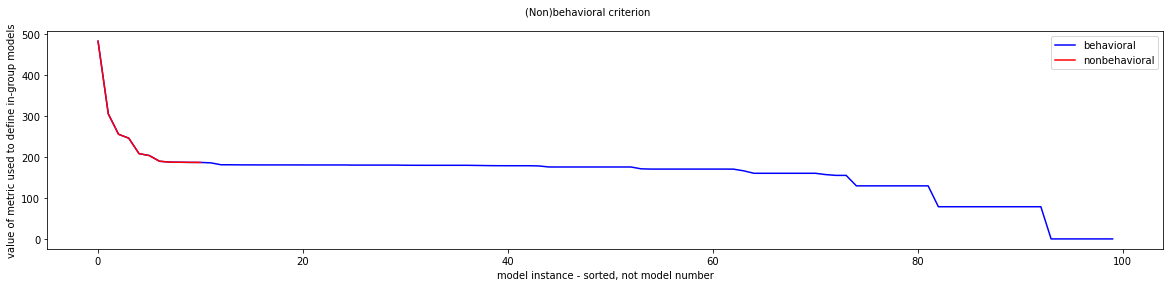

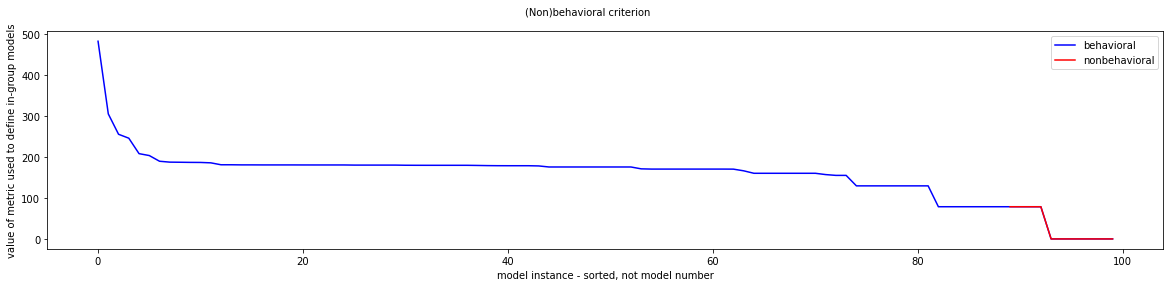

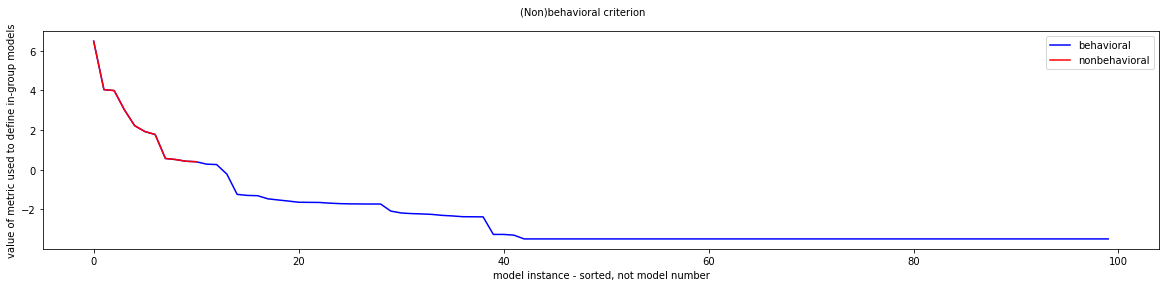

There were  39 models of concern.

Models of concern:
m001001331100244
m001001331232114
m001001331332234
m001001331430314
m001001332014344
m001001332023213
m001001332110424
m001001332214123
m001001332441313
m001001333013423
m001001333102114
m001001333142343
m001001333142434
m001001333201343
m001001333222424
m001001333243004
m001001333320244
m001001333330413
m001001333333333
m001001333401124
m001001333410313
m001001333413423
m001001334011004
m001001334013223
m001001334034344
m001001334042422
m001001334043213
m001001334110344
m001001334111203
m001001334130212
m001001334143003
m001001334233144
m001001334302344
m001001334320024
m001001334343042
m001001334400012
m001001334413303
m001001334420024
m001001334434122

Assessing prevalence of each parameter for models of concern and other models

                                              Ky    low Kz   Sy    Rm      ETv     ETr   Kstr

Models of concern average ---------------- [0.538 1.692 1.821 1.487 2.077 2.128 1.59 ]
Models of concern sta

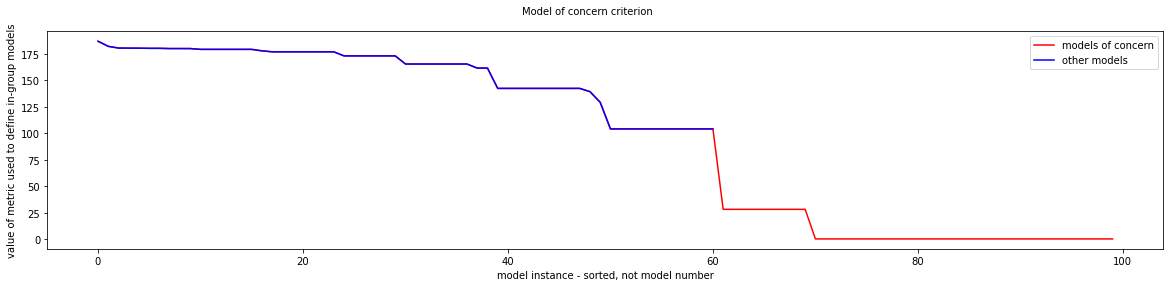

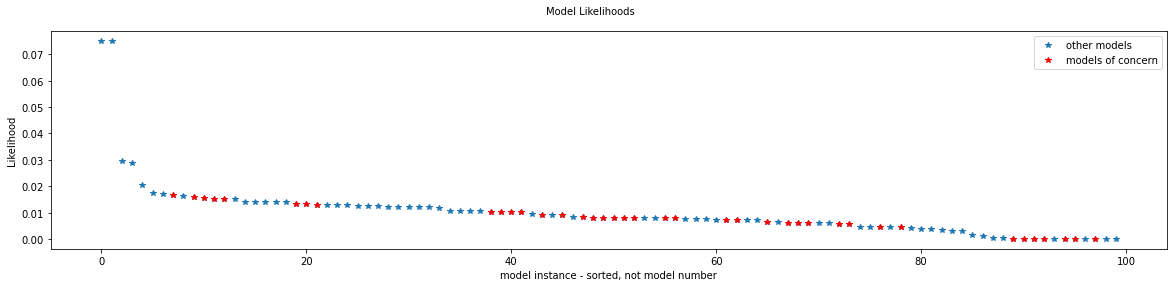

Models with highest likelihoods

m001001330022410  L = 0.074 other model
m001001330030142  L = 0.074 other model
m001001330030143  L = 0.029 other model
m001001330041044  L = 0.028 other model
m001001330200120  L = 0.02 other model
m001001330202214  L = 0.017 other model
m001001330212434  L = 0.017 other model
m001001330214440  L = 0.016 model of concern
m001001330231201  L = 0.016 other model
m001001330240302  L = 0.015 model of concern

The total likelihood of the models of concern is  0.301


In [21]:
print('The final ensemble includes ',np.shape(runnumbers)[0],' models')
print()

if np.shape(nonbehavioral_ids)[0]>0:
    print('There were ', np.shape(nonbehavioral_ids)[0],'non-behavioral models.')
    print()
    print('Non-behavioral models:')
    for i in np.arange(np.shape(nonbehavioral_ids)[0]):
        print(nonbehavioral_ids[i])
    print()
    print('There were ', np.shape(Lcut_ids)[0],'low likelihood models.')
    if np.shape(Lcut_ids)[0]>0 and lowLecho==True:
        print()
        print('Low-likelihood models:')
        for i in Lcut_ids:
            print(runnumbers[i])
    print()
print('Assessing prevalence of each parameter for behavioral and non-behavioral models')
print()
print('                                       Ky    low Kz   Sy    Rm      ETv     ETr   Kstr')
print()
print('Behavioral average ----------------',np.floor(b_meanid*1000)/1000)
print('Behavioral deviation --------------',np.floor(b_varid*1000)/1000)
print()
plottitle='(Non)behavioral criterion'
if np.shape(nonbehavioral_ids)[0]>0:
    print('Non-behavioral average ------------',np.floor(nonb_meanid*1000)/1000)
    print('Non-behavioral standard deviation -',np.floor(nonb_varid*1000)/1000)
    print()
    for ij in np.arange(np.shape(holdplotx)[0]):
        if holdplottype[ij]==0:
            f0,ax1 = plt.subplots(1,1,figsize=(20,4))                                             # create & return figure & axes at position (row, col) of size 20x12 inches
            tempplotx=holdplotx[ij][:]
            tempploty=holdploty[ij][:]
            c = ax1.plot(tempplotx,tempploty,color="blue",label='behavioral')     
            tempplotx=tempplotx[holdleftlimit[ij]:holdrightlimit[ij]]
            tempploty=tempploty[holdleftlimit[ij]:holdrightlimit[ij]]
            c = ax1.plot(tempplotx,tempploty,color="red",label='nonbehavioral')     
            ax1.set_xlabel('model instance - sorted, not model number')
            ax1.set_ylabel('value of metric used to define in-group models')
            ax1.legend()
            plt.figtext(0.5, 0.95, plottitle, ha='center', va='center')
            plt.show(f0)   
        else:
            skipprint=1

else:
    print('All models are behavioral')

if run_sections>0:
    if np.shape(moc_ids)[0]>0:
        print('There were ', np.shape(moc_ids)[0],'models of concern.')
        print()
        print('Models of concern:')
        for i in np.arange(np.shape(moc_ids)[0]):
            print(moc_ids[i])
        print()

    print('Assessing prevalence of each parameter for models of concern and other models')
    print()
    print('                                              Ky    low Kz   Sy    Rm      ETv     ETr   Kstr')
    print()
    print('Models of concern average ----------------',np.floor(moc_meanid*1000)/1000)
    print('Models of concern standard deviation -----',np.floor(moc_varid*1000)/1000)
    print()
    plottitle='Model of concern criterion'
    if np.shape(moc_ids)[0]>0:
        print('Other model average ----------------------',np.floor(other_meanid*1000)/1000)
        print('Other model standard deviation -----------',np.floor(other_varid*1000)/1000)
        print()
        moccounter=-1
        for ij in np.arange(np.shape(holdplotx)[0]):
            if holdplottype[ij]==1:
                moccounter=moccounter+1
                f1,ax1 = plt.subplots(1,1,figsize=(20,4))                                             # create & return figure & axes at position (row, col) of size 20x12 inches
                tempplotx=holdplotx[ij][:]
                tempploty=holdploty[ij][:]
                c = ax1.plot(tempplotx,tempploty,color="red",label='models of concern')     
                tempplotx=tempplotx[int(holdleftlimit[ij]):int(holdrightlimit[ij])]
                tempploty=tempploty[int(holdleftlimit[ij]):int(holdrightlimit[ij])]
                c = ax1.plot(tempplotx,tempploty,color="blue",label='other models')     
                ax1.set_xlabel('model instance - sorted, not model number')
                ax1.set_ylabel('value of metric used to define in-group models')
                plt.figtext(0.5, 0.95, plottitle, ha='center', va='center')
                ax1.legend()
                plt.show(f1)     
            else:
                skipprint=1
    else:
        print('There are no models of concern')

    plottitle='Model Likelihoods'
    f2,ax1 = plt.subplots(1,1,figsize=(20,4))                                                         # create & return figure & axes at position (row, col) of size 20x12 inches
    xplot=np.arange(len(runnumbers))                                                                  # plot sorted streamflows against number of runs
    c = ax1.plot(xplot,sorted_L,'*',label='other models')   
    tempvar=np.argsort(-L)
    xplot=np.zeros(np.shape(moc_ids_counter)[0])
    yplot=np.zeros(np.shape(moc_ids_counter)[0])
    count=-1
    Lsum_moc=0
    for i in np.arange(np.shape(tempvar)[0]):  
        if np.shape(np.intersect1d(tempvar[i],moc_ids_counter))[0]>0:
            count=count+1
            xplot[count]=(i)
            yplot[count]=(L[tempvar[i]])
            Lsum_moc=Lsum_moc+L[tempvar[i]]                                                           # keep track of total L in MOCs
    c = ax1.plot(xplot,yplot,'*',color="Red",label='models of concern')   
    ax1.set_xlabel('model instance - sorted, not model number')
    ax1.set_ylabel('Likelihood')
    plt.figtext(0.5, 0.95, plottitle, ha='center', va='center')
    ax1.legend()
    plt.show(f2)     

    print('Models with highest likelihoods')
    print()
    bestmodels=np.argsort(-L)
    numbest=np.shape(bestmodels)[0]
    if numbest>10:
        numbest=10

    for i in range(numbest):
        if runnumbers[bestmodels[i]] in moc_ids:
            print(runnumbers[i],' L =', np.floor(L[bestmodels[i]]*1000)/1000, 'model of concern')
        else:
            print(runnumbers[i],' L =', np.floor(L[bestmodels[i]]*1000)/1000, 'other model')

    print()
    print('The total likelihood of the models of concern is ',np.floor(Lsum_moc*1000)/1000)

    del plottitle                                                                                     # clear temporary variables
    del tempplotx
    del tempploty
    del skipprint
#     del bestmodels
    del numbest
    del count
    del xplot
    del yplot
    del tempvar

In [22]:
print(sorted_L[0:10])

[0.07496935 0.07496935 0.02945126 0.02875748 0.02058587 0.0174103
 0.01717532 0.01676146 0.01646111 0.01588398]


**GENERATE HEAD-RELATED CONTOUR PLOTS**
   

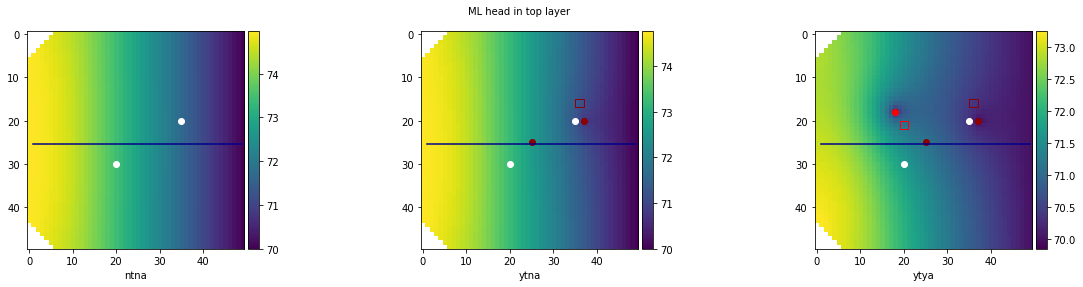

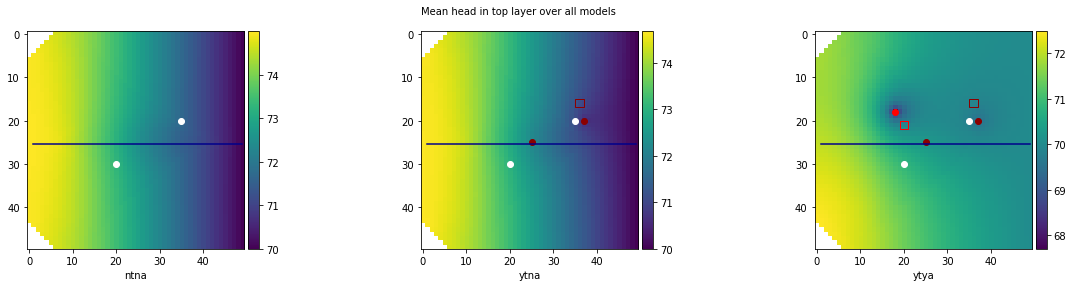

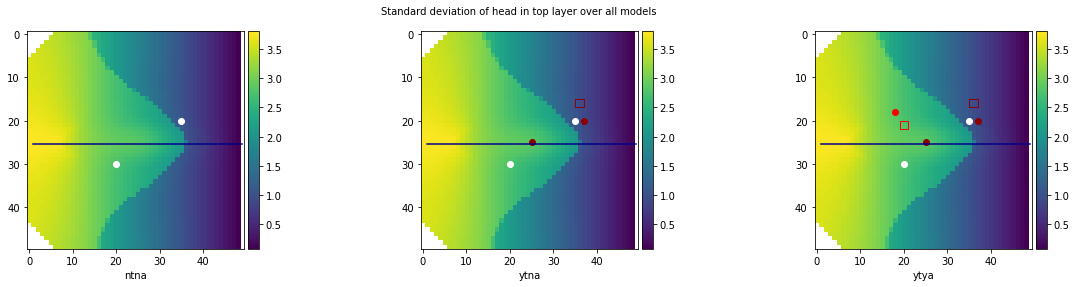

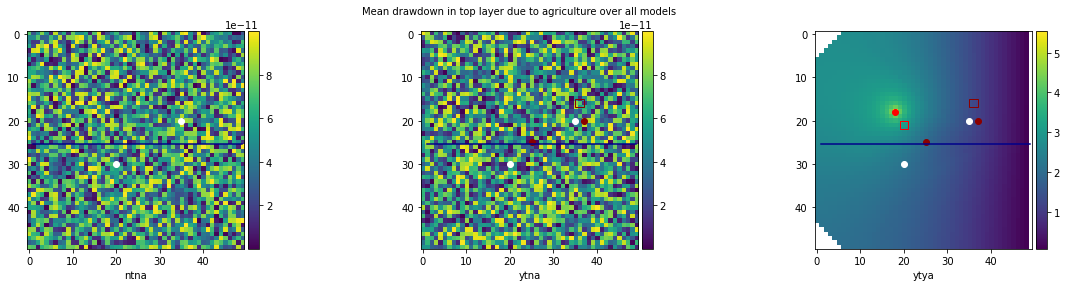

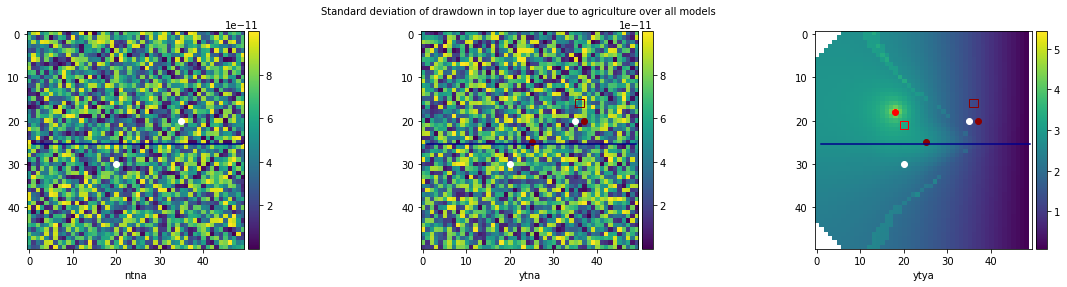

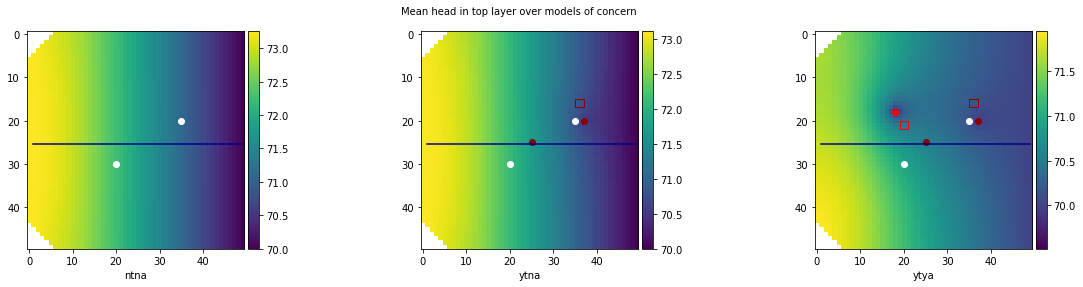

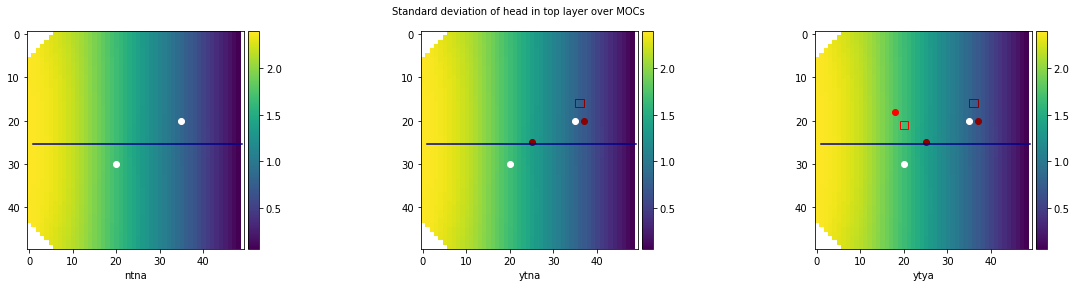

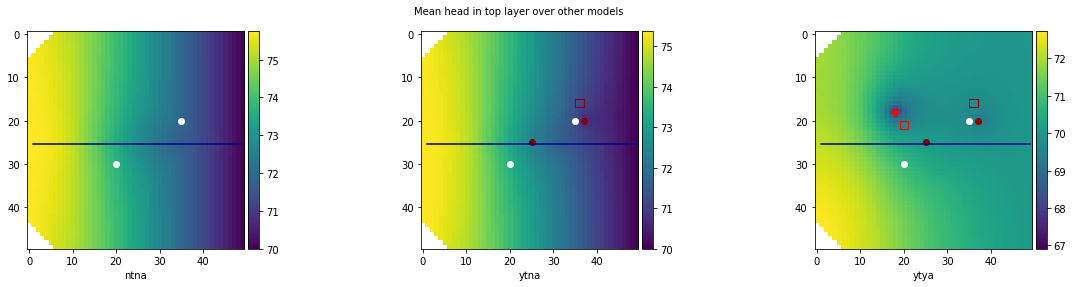

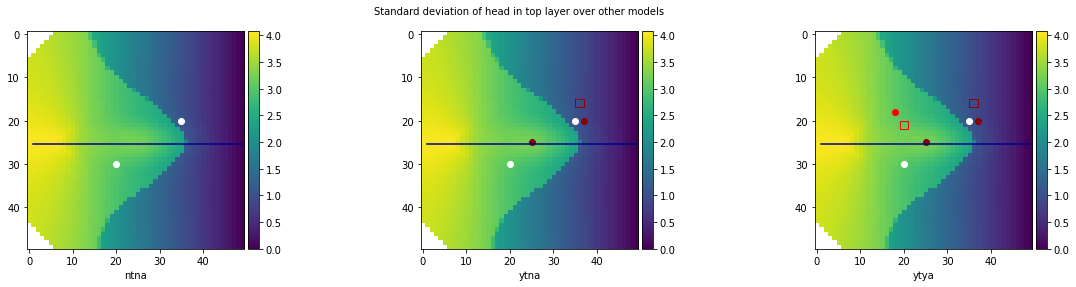

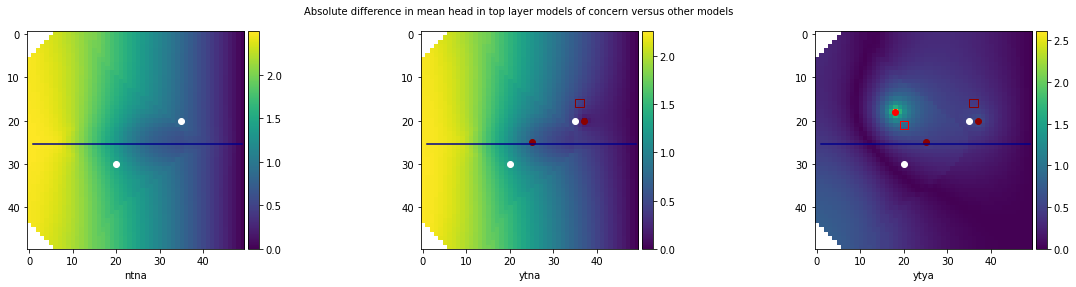

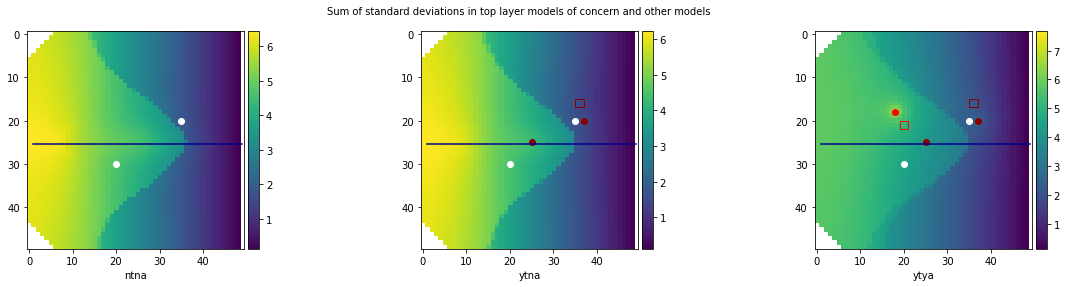

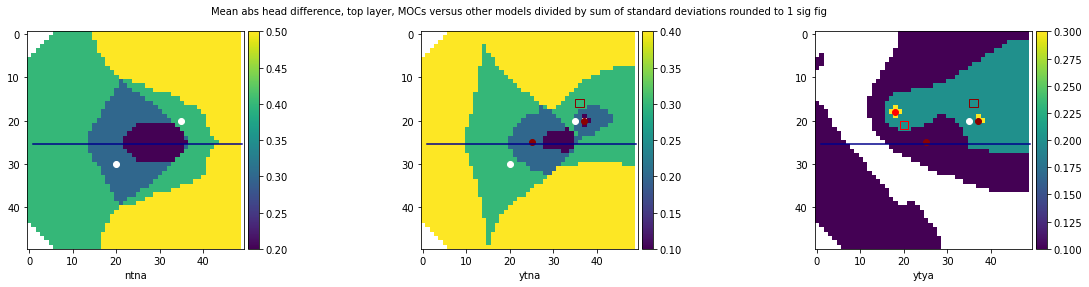

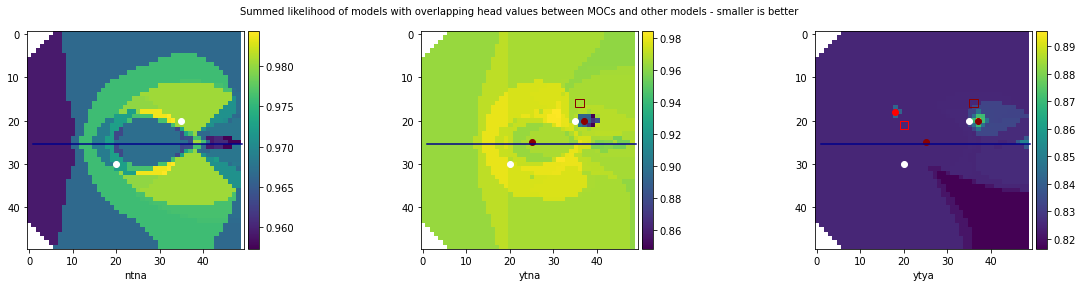

ValueError: arange: cannot compute length

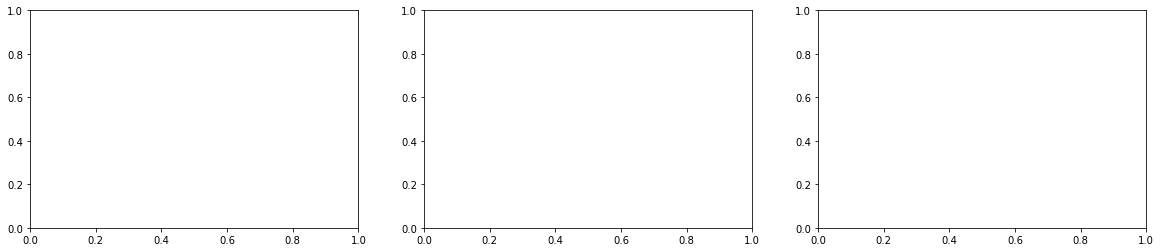

In [23]:
def make_contour_plot(ncol,nrow,data_ntna,data_ytna,data_ytya,minval,plottitle):                  # function to create contour plots                                                      # use this to generate contour plots with streams, wells, return locations, infiltration areas and add x axis titles
    extent = (0, ncol, 0, nrow)                                                                   # sets plot boundaries (x0,x1,y0,y1)
    for t in np.arange(3):                                                                        # one plot for each steady state condition
        if t==0:
            h=data_ntna
        elif t==1:
            h=data_ytna
        else:
            h=data_ytya
        h[h==0]=np.nan                                                                            # remove false zero values to improve color fill limits
        levels = np.arange(np.nanmin(h),np.nanmax(h),(np.nanmax(h)-np.nanmin(h))/100)             # creates an array of values used to determine which contour values to draw
        ax1[t].invert_yaxis()                                                                     # reverse y axis direction so that row 0 is at the top

#         c = ax1[t].contour(h, extent=extent, levels=levels, colors='SteelBlue')                 # plot contours for all rows & columns in layer 1
        im = ax1[t].imshow(h,cmap=cm.viridis)                                                     # plot head as a colormap
        divider = make_axes_locatable(ax1[t])                                                     # set up colorbar location (need to import make_axes_locatable - see top cell)
        cax = divider.append_axes("right", size="5%", pad=0.05)                                   # place colorbar axes on right side of each subplot
        plt.colorbar(mappable=im, cax = cax)                                                      # draw colorbar
        ax1[t].plot(str_cols, str_rows+.5, c='DarkBlue')                                          # plot stream location (col = x, row = y)
        for ij in np.arange(np.shape(data_basis_sequence)[0]):
            ax1[t].scatter(data_column_sequence[ij], data_row_sequence[ij], c='White')
        if t>0:
            ax1[t].scatter(well1[2], well1[1], c='DarkRed')                                       # plot town well location (col = x, row = y)
            ax1[t].scatter(return_loc,25, c='DarkRed')                                            # plots town return location (col = x, row = y)
            townrect = patches.Rectangle((rNWc[2],rNWc[1]),2,2,linewidth=1,
                 edgecolor='DarkRed',facecolor='none')
            ax1[t].add_patch(townrect)
        if t>1:
            ax1[t].scatter(well2[2], well2[1], c='Red')                                           # plot irrigation well location (col = x, row = y)
            farmrect = patches.Rectangle((fNWc[1],fNWc[0]),2,2,linewidth=1,
                 edgecolor='Red',facecolor='none')
            ax1[t].add_patch(farmrect)                                                            # plot farm irrigation area
        if t==0:                                       
            ax1[t].set_xlabel('ntna')                                                             # label x axis to identify steady state condition
        elif t==1:      
            ax1[t].set_xlabel('ytna')
            plt.figtext(0.5, 0.95, plottitle, ha='center', va='center')
        else:
            ax1[t].set_xlabel('ytya') 

if run_sections>-1:
    print()
    plottitle='ML head in top layer'
    minval=0                                                                                          # minimum allowable value ... only used for difference plot to identify measurable differences
    data_ntna=headML_ss_ntna
    data_ntna[np.isnan(data_ntna)]=-1
    data_ytna=headML_ss_ytna
    data_ytya=headML_ss_ytya
    f3aa,ax1 = plt.subplots(1,3,figsize=(20,4))                                                         # create & return figure & axes at position (row, col) of size 20x12 inches
    make_contour_plot(ncol,nrow,data_ntna,data_ytna,data_ytya,minval,plottitle) 
    plt.show(f3aa)  

    print()
    plottitle='Mean head in top layer over all models'
    minval=0                                                                                          # minimum allowable value ... only used for difference plot to identify measurable differences
    data_ntna=headmean_ss_ntna
    data_ntna[np.isnan(data_ntna)]=-1
    data_ytna=headmean_ss_ytna
    data_ytya=headmean_ss_ytya
    f3a,ax1 = plt.subplots(1,3,figsize=(20,4))                                                         # create & return figure & axes at position (row, col) of size 20x12 inches
    make_contour_plot(ncol,nrow,data_ntna,data_ytna,data_ytya,minval,plottitle) 
    plt.show(f3a)  

    plottitle='Standard deviation of head in top layer over all models'
    minval=0                                                                                          # minimum allowable value ... only used for difference plot to identify measurable differences
    data_ntna=headvar_ss_ntna
    data_ytna=headvar_ss_ntna
    data_ytya=headvar_ss_ntna
    f3b,ax1 = plt.subplots(1,3,figsize=(20,4))                                                         # create & return figure & axes at position (row, col) of size 20x12 inches
    make_contour_plot(ncol,nrow,data_ntna,data_ytna,data_ytya,minval,plottitle)
    plt.show(f3b)     

    print()
    plottitle='Mean drawdown in top layer due to agriculture over all models'
    minval=0                                                                                          # minimum allowable value ... only used for difference plot to identify measurable differences
    data_ntna=np.random.rand(np.shape(ddmean)[0],np.shape(ddmean)[0])*1e-10
    data_ytna=np.random.rand(np.shape(ddmean)[0],np.shape(ddmean)[0])*1e-10
    data_ytya=ddmean
    f7a,ax1 = plt.subplots(1,3,figsize=(20,4))                                                         # create & return figure & axes at position (row, col) of size 20x12 inches
    make_contour_plot(ncol,nrow,data_ntna,data_ytna,data_ytya,minval,plottitle)
    plt.show(f7a)     

    print()
    plottitle='Standard deviation of drawdown in top layer due to agriculture over all models'
    minval=0                                                                                          # minimum allowable value ... only used for difference plot to identify measurable differences
    data_ntna=np.random.rand(np.shape(ddmean)[0],np.shape(ddmean)[0])*1e-10
    data_ytna=np.random.rand(np.shape(ddmean)[0],np.shape(ddmean)[0])*1e-10
    data_ytya=ddvar
    f7b,ax1 = plt.subplots(1,3,figsize=(20,4))                                                         # create & return figure & axes at position (row, col) of size 20x12 inches
    make_contour_plot(ncol,nrow,data_ntna,data_ytna,data_ytya,minval,plottitle)
    plt.show(f7b)     


if run_sections>0:
    if np.shape(moc_ids_counter)[0] > 0:
        print()
        plottitle='Mean head in top layer over models of concern'
        minval=0                                                                                      # minimum allowable value ... only used for difference plot to identify measurable differences
        data_ntna=moc_headmean_ss_ntna
        data_ytna=moc_headmean_ss_ytna
        data_ytya=moc_headmean_ss_ytya
        f4a,ax1 = plt.subplots(1,3,figsize=(20,4))                                                     # create & return figure & axes at position (row, col) of size 20x12 inches
        make_contour_plot(ncol,nrow,data_ntna,data_ytna,data_ytya,minval,plottitle)
        plt.show(f4a)     

        plottitle='Standard deviation of head in top layer over MOCs'
        minval=0                                                                                      # minimum allowable value ... only used for difference plot to identify measurable differences
        data_ntna=moc_headvar_ss_ntna
        data_ytna=moc_headvar_ss_ntna
        data_ytya=moc_headvar_ss_ntna
        f4b,ax1 = plt.subplots(1,3,figsize=(20,4))                                                     # create & return figure & axes at position (row, col) of size 20x12 inches
        make_contour_plot(ncol,nrow,data_ntna,data_ytna,data_ytya,minval,plottitle)
        plt.show(f4b)     

        print()
        plottitle='Mean head in top layer over other models'
        minval=0                                                                                      # minimum allowable value ... only used for difference plot to identify measurable differences
        data_ntna=other_headmean_ss_ntna
        data_ytna=other_headmean_ss_ytna
        data_ytya=other_headmean_ss_ytya
        f5a,ax1 = plt.subplots(1,3,figsize=(20,4))                                                     # create & return figure & axes at position (row, col) of size 20x12 inches
        make_contour_plot(ncol,nrow,data_ntna,data_ytna,data_ytya,minval,plottitle)
        plt.show(f5a)     

        plottitle='Standard deviation of head in top layer over other models'
        minval=0                                                                                      # minimum allowable value ... only used for difference plot to identify measurable differences
        data_ntna=other_headvar_ss_ntna
        data_ytna=other_headvar_ss_ntna
        data_ytya=other_headvar_ss_ntna
        f5b,ax1 = plt.subplots(1,3,figsize=(20,4))                                                     # create & return figure & axes at position (row, col) of size 20x12 inches
        make_contour_plot(ncol,nrow,data_ntna,data_ytna,data_ytya,minval,plottitle)
        plt.show(f5b)     

if run_sections>1:
    if np.shape(moc_ids_counter)[0] > 0:
        print()
        plottitle='Absolute difference in mean head in top layer models of concern versus other models'
        minval=0.1                                                                                    # minimum allowable value ... only used for difference plot to identify measurable differences
        data_ntna=meandiff_ntna
        data_ytna=meandiff_ytna
        data_ytya=meandiff_ytya
        f6a,ax1 = plt.subplots(1,3,figsize=(20,4))                                                     # create & return figure & axes at position (row, col) of size 20x12 inches
        make_contour_plot(ncol,nrow,data_ntna,data_ytna,data_ytya,minval,plottitle)
        plt.show(f6a)     

        print()
        plottitle='Sum of standard deviations in top layer models of concern and other models'
        minval=0                                                                                      # minimum allowable value ... only used for difference plot to identify measurable differences
        data_ntna=sumvar_ntna
        data_ytna=sumvar_ytna
        data_ytya=sumvar_ytya
        f6b,ax1 = plt.subplots(1,3,figsize=(20,4))                                                     # create & return figure & axes at position (row, col) of size 20x12 inches
        make_contour_plot(ncol,nrow,data_ntna,data_ytna,data_ytya,minval,plottitle)
        plt.show(f6b)     

        print()
        plottitle='Mean abs head difference, top layer, MOCs versus other models divided by sum of standard deviations rounded to 1 sig fig'
        minval=0                                                                                      # minimum allowable value ... only used for difference plot to identify measurable differences
        data_ntna=di_std_ntna
        data_ytna=di_std_ytna
        data_ytya=di_std_ytya
        f6c,ax1 = plt.subplots(1,3,figsize=(20,4))                                                     # create & return figure & axes at position (row, col) of size 20x12 inches
        make_contour_plot(ncol,nrow,np.round(10*data_ntna)/10,np.round(10*data_ytna)/10,
             np.round(10*data_ytya)/10,minval,plottitle)
        plt.show(f6c)

        print()
        plottitle='Summed likelihood of models with overlapping head values between MOCs and other models - smaller is better'
        minval=0                                                                                      # minimum allowable value ... only used for difference plot to identify measurable differences
        data_ntna=overlap_ntna_head
        data_ytna=overlap_ytna_head
        data_ytya=overlap_ytya_head
        f6d,ax1 = plt.subplots(1,3,figsize=(20,4))                                                     # create & return figure & axes at position (row, col) of size 20x12 inches
        make_contour_plot(ncol,nrow,data_ntna,data_ytna,data_ytya,minval,plottitle)
        plt.show(f6d)     

        print()
        plottitle='Mean abs head difference, top layer, MOCs versus other models multiplied by (1-overlap) - rounded to 1 sig fig'
        minval=0                                                                                      # minimum allowable value ... only used for difference plot to identify measurable differences
        data_ntna=di_overlap_ntna
        data_ytna=di_overlap_ytna
        data_ytya=di_overlap_ytya
        f6e,ax1 = plt.subplots(1,3,figsize=(20,4))                                                     # create & return figure & axes at position (row, col) of size 20x12 inches
        make_contour_plot(ncol,nrow,np.round(10*data_ntna)/10,np.round(10*data_ytna)/10,
             np.round(10*data_ytya)/10,minval,plottitle)
        plt.show(f6e)     

        #Export files needed for multi-stakeholder comparisons:
        #To import, use np.load()
        comparison_directory()               #change directory to current stakeholder and stage
        np.save(prefix + 'di_std', di_std_ytna)
        output_directory()

    del minval
    del data_ntna
    del data_ytna
    del data_ytya
    del plottitle

**GENERATE PARTICLE-RELATED CONTOUR PLOTS**
   

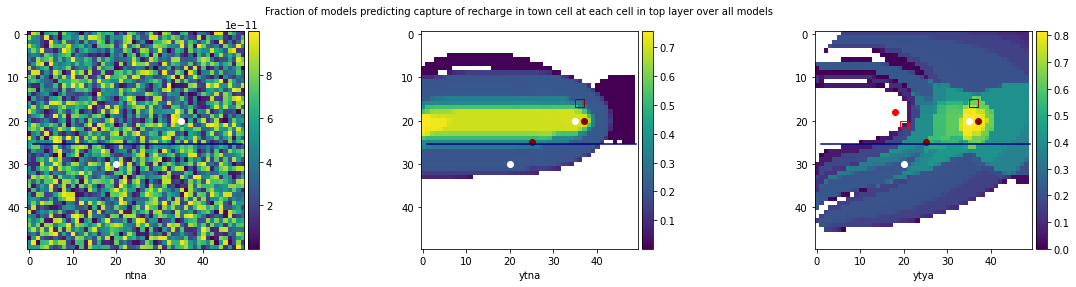

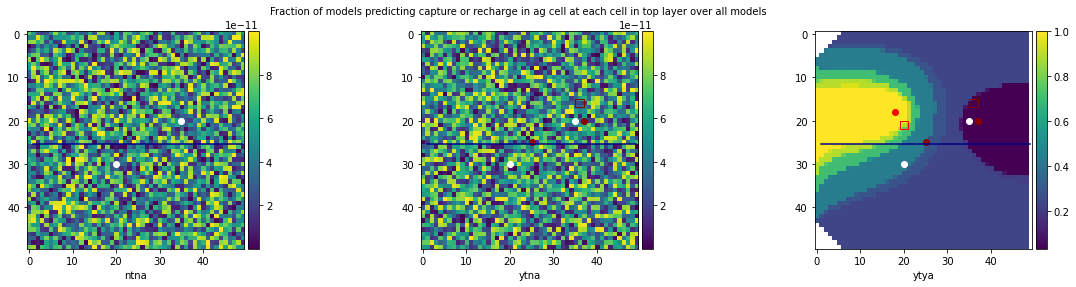

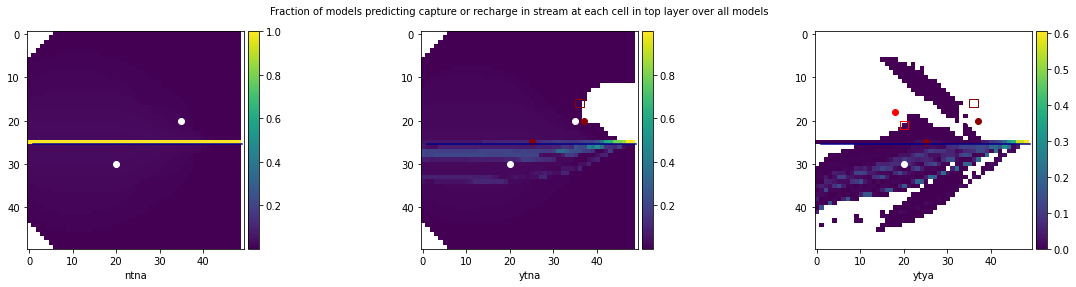

In [29]:
if run_sections>2:
    plottitle='Fraction of models predicting capture of recharge in town cell at each cell in top layer over all models'
    minval=0                                                                                           # minimum allowable value ... only used for difference plot to identify measurable differences
    data_ntna=np.random.rand(np.shape(ddmean)[0],np.shape(ddmean)[0])*1e-10
    data_ytna=w1capgrid[1][:][:]
    data_ytya=w1capgrid[2][:][:]
    
    f8a,ax1 = plt.subplots(1,3,figsize=(20,4))                                                          # create & return figure & axes at position (row, col) of size 20x12 inches
    make_contour_plot(ncol,nrow,data_ntna,data_ytna,data_ytya,minval,plottitle)
    plt.show(f8a)

    print()
    plottitle='Fraction of models predicting capture or recharge in ag cell at each cell in top layer over all models'
    minval=0                                                                                           # minimum allowable value ... only used for difference plot to identify measurable differences
    data_ntna=np.random.rand(np.shape(ddmean)[0],np.shape(ddmean)[0])*1e-10
    data_ytna=np.random.rand(np.shape(ddmean)[0],np.shape(ddmean)[0])*1e-10
    data_ytya=w2capgrid[2][:][:]
    f8b,ax1 = plt.subplots(1,3,figsize=(20,4))                                                          # create & return figure & axes at position (row, col) of size 20x12 inches
    make_contour_plot(ncol,nrow,data_ntna,data_ytna,data_ytya,minval,plottitle)
    plt.show(f8b)

    print()
    plottitle='Fraction of models predicting capture or recharge in stream at each cell in top layer over all models'
    minval=0                                                                                           # minimum allowable value ... only used for difference plot to identify measurable differences
    data_ntna=strcapgrid[0][:][:]
    data_ytna=strcapgrid[1][:][:]
    data_ytya=strcapgrid[2][:][:]
    f8c,ax1 = plt.subplots(1,3,figsize=(20,4))                                                          # create & return figure & axes at position (row, col) of size 20x12 inches
    make_contour_plot(ncol,nrow,data_ntna,data_ytna,data_ytya,minval,plottitle)
    plt.show(f8c)

    del minval                                                                                         # clear temporary variables
    del plottitle
    del data_ntna
    del data_ytna
    del data_ytya

**GENERATE TRANSECT PLOTS ALONG STREAM**
   

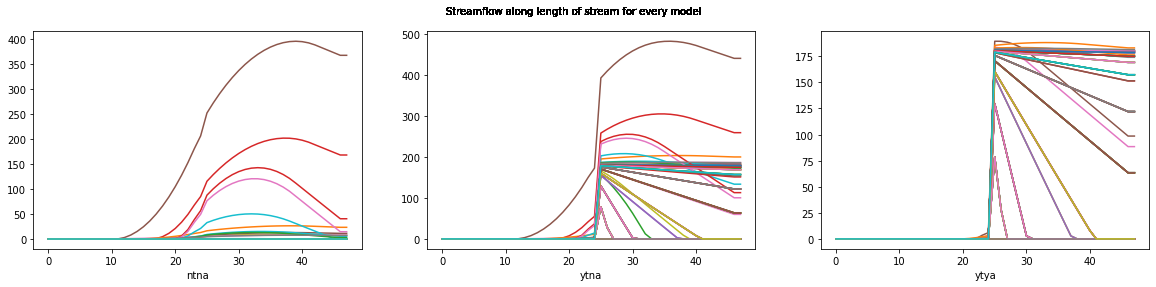

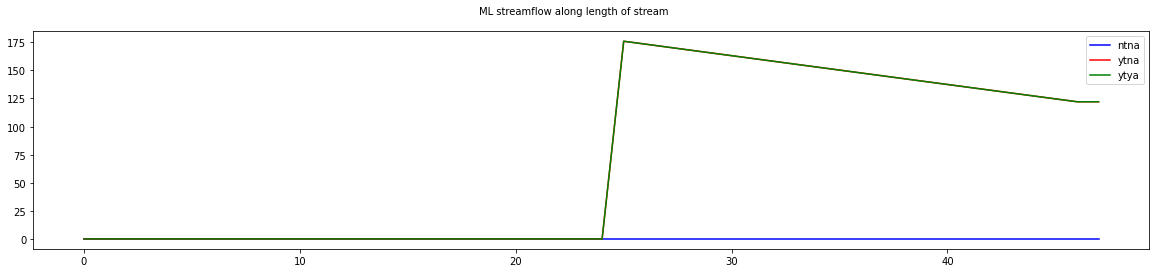

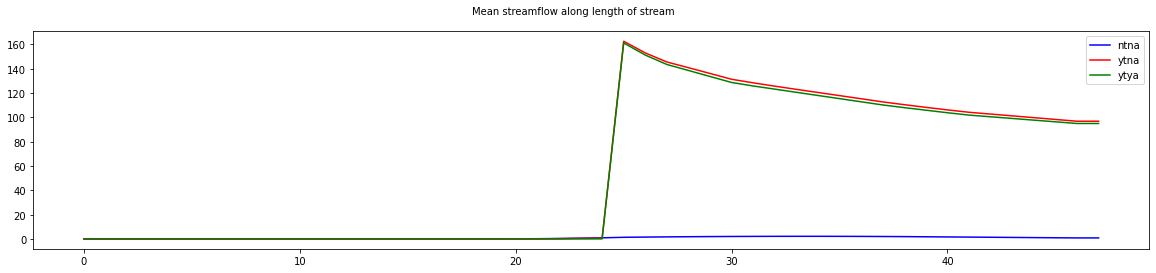

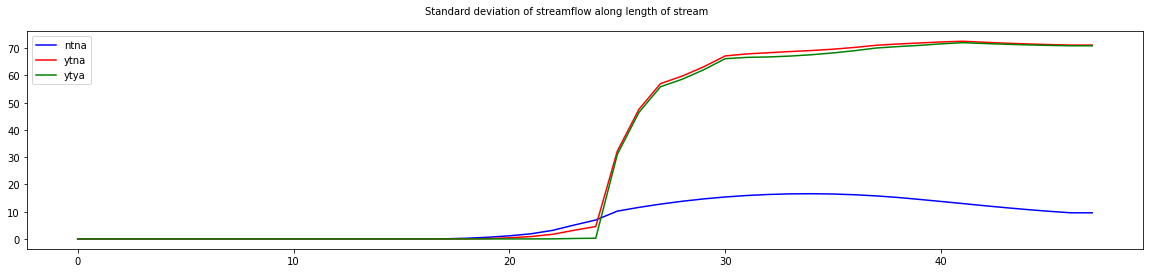

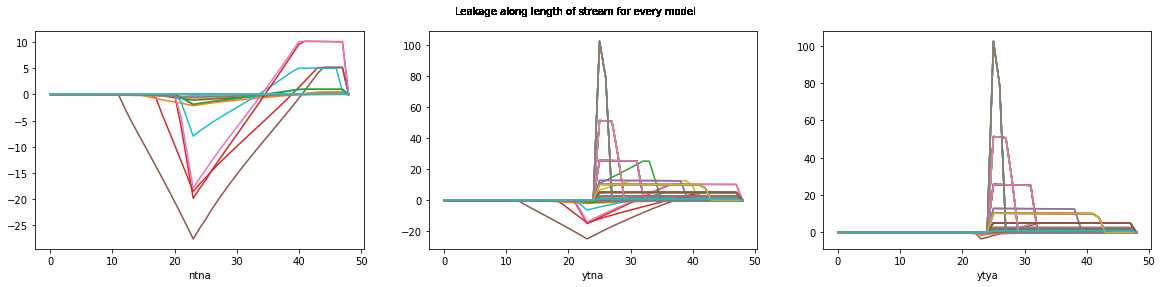

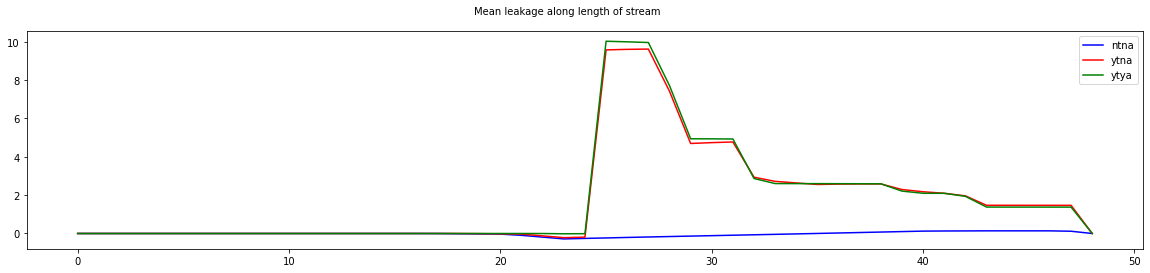

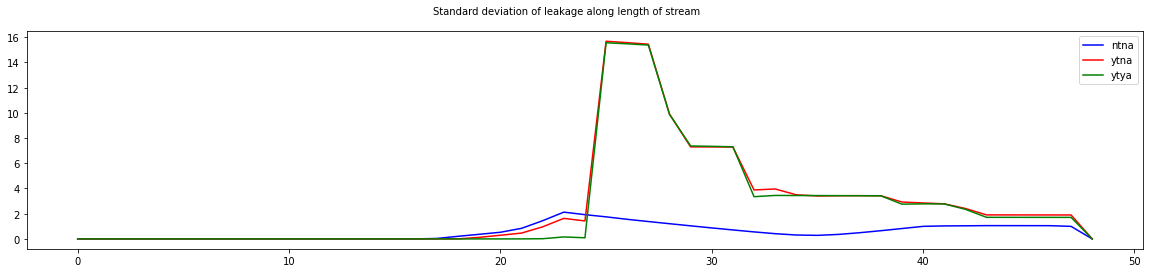

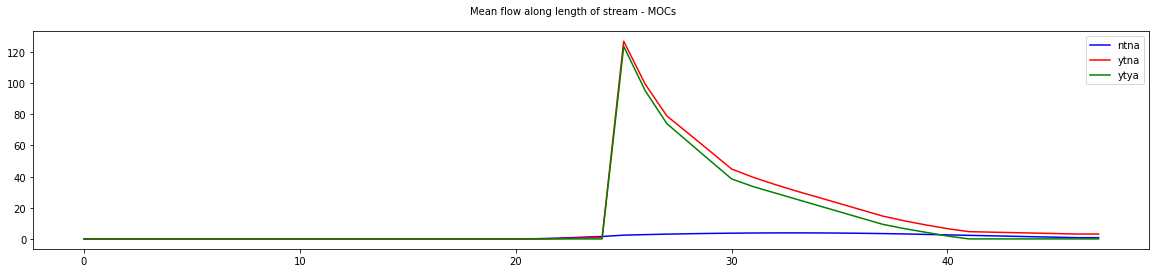

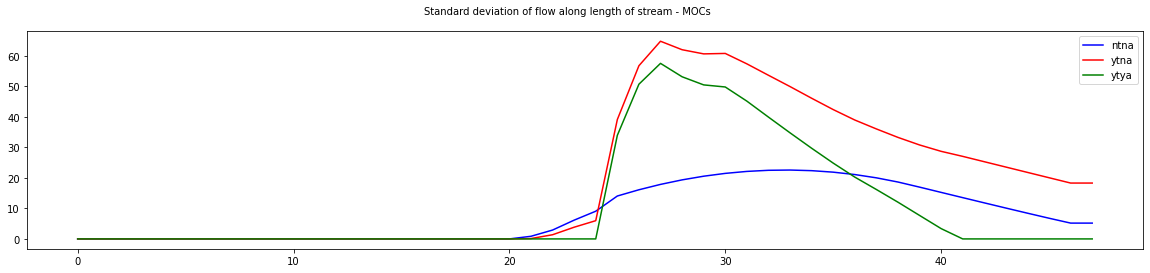

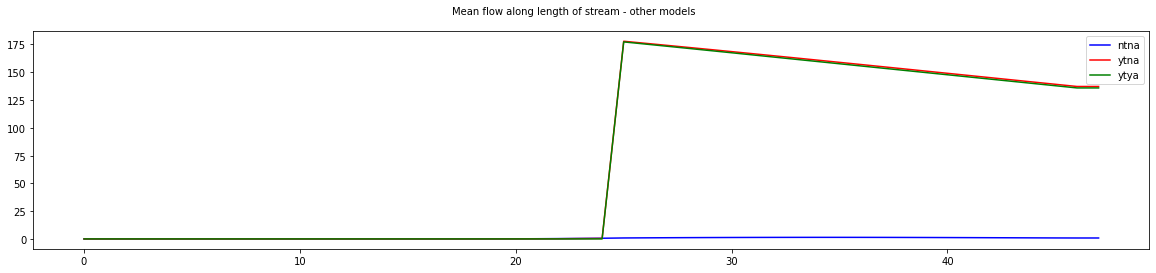

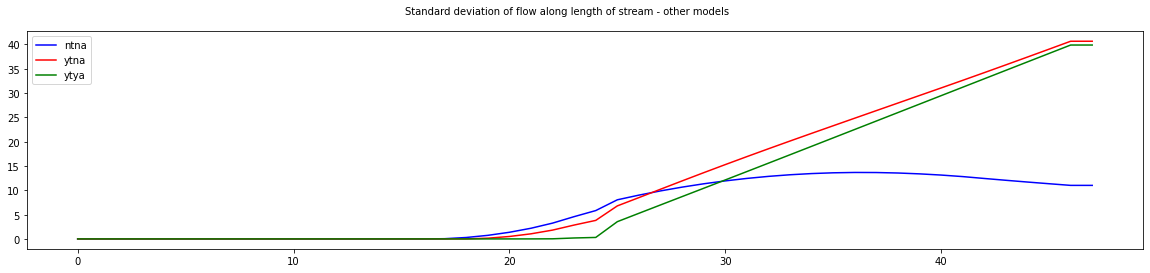

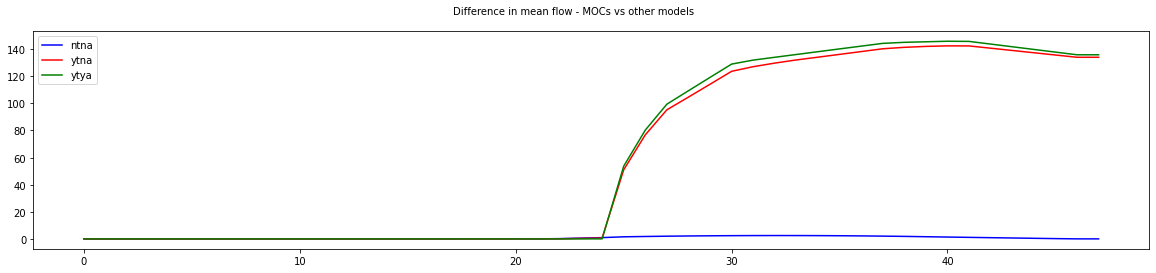

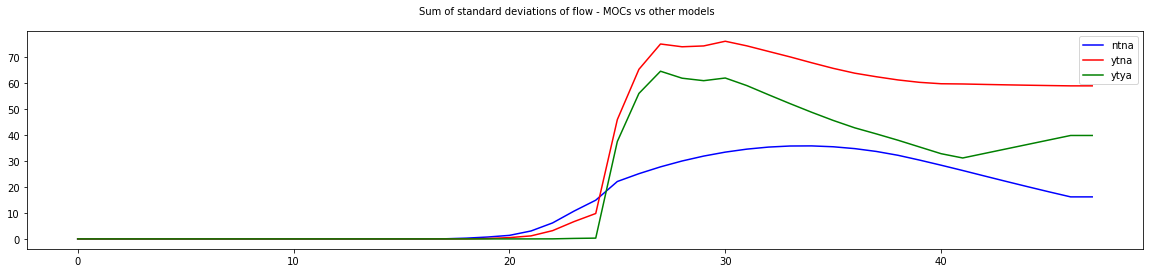

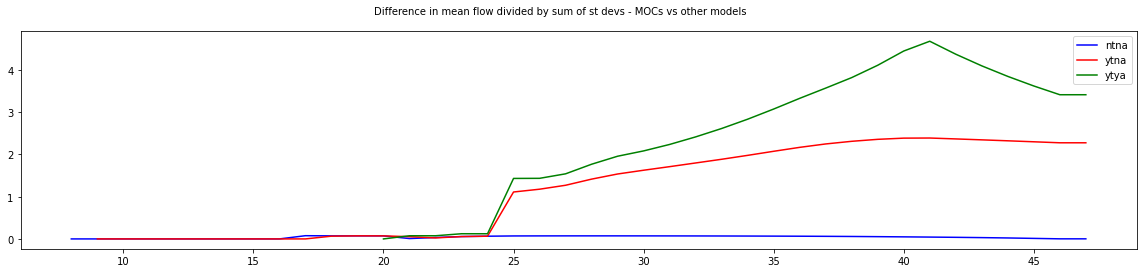

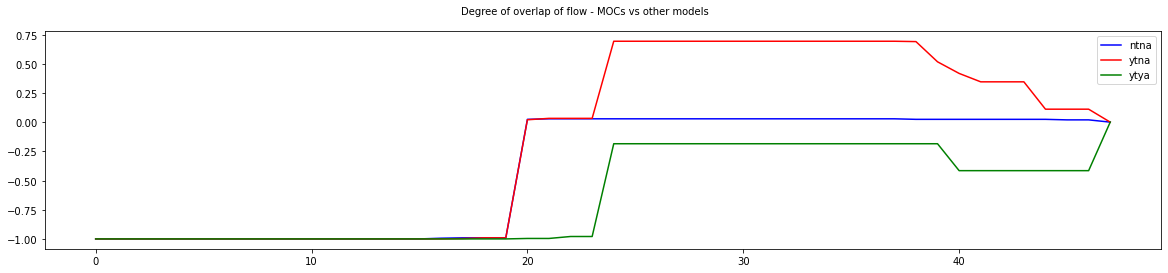

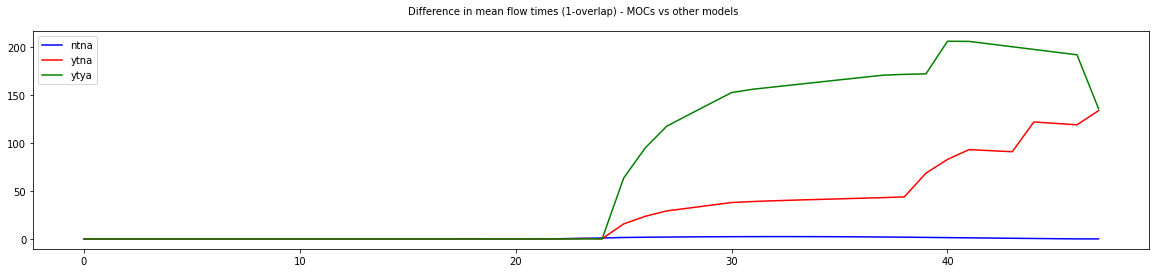

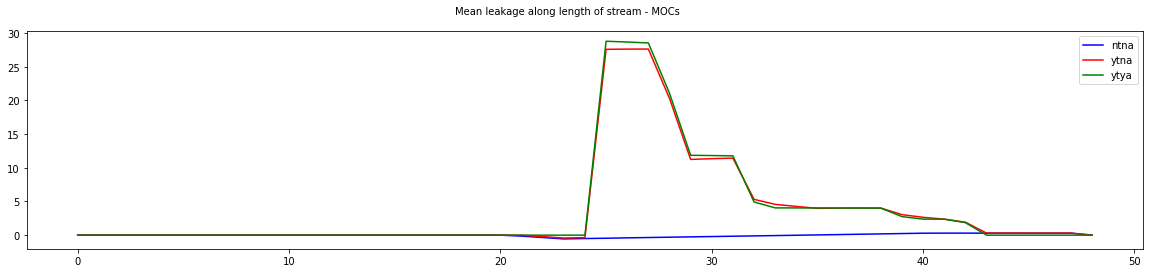

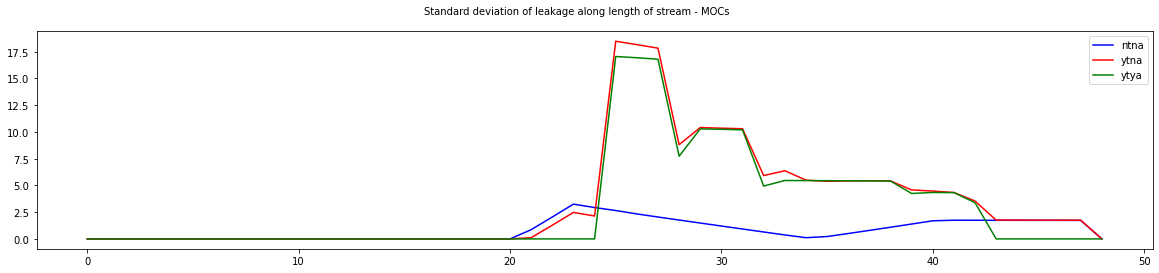

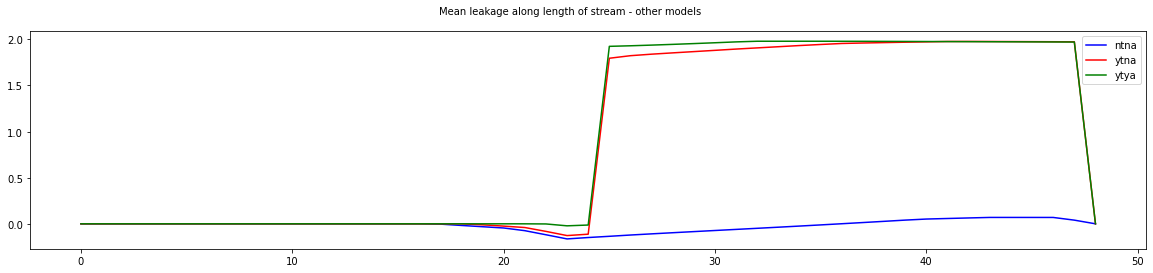

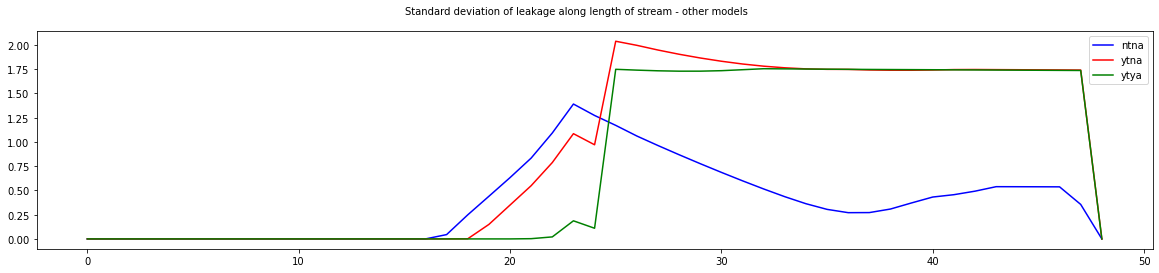

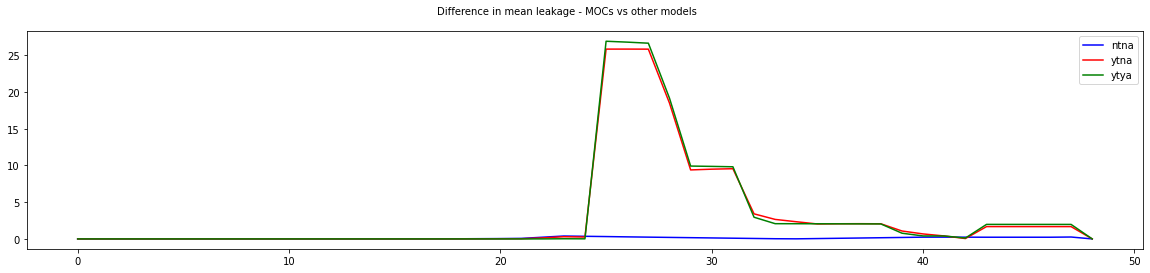

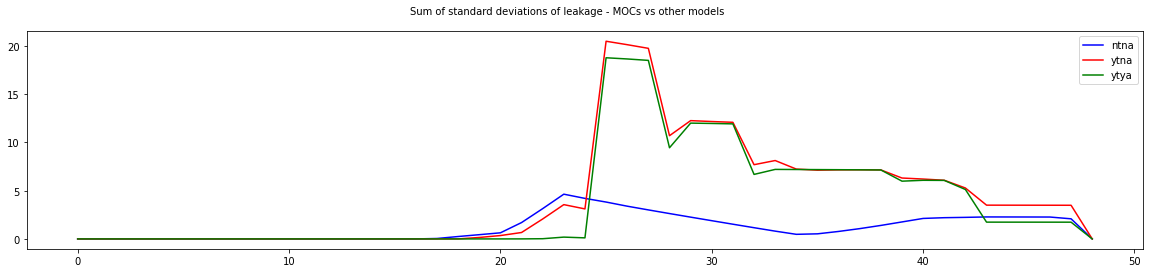

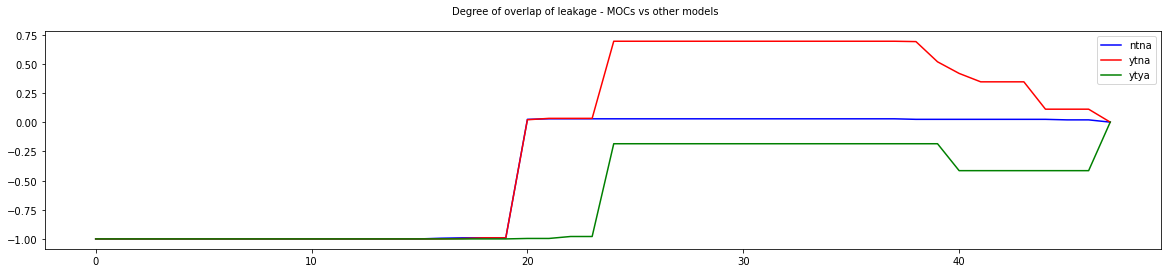

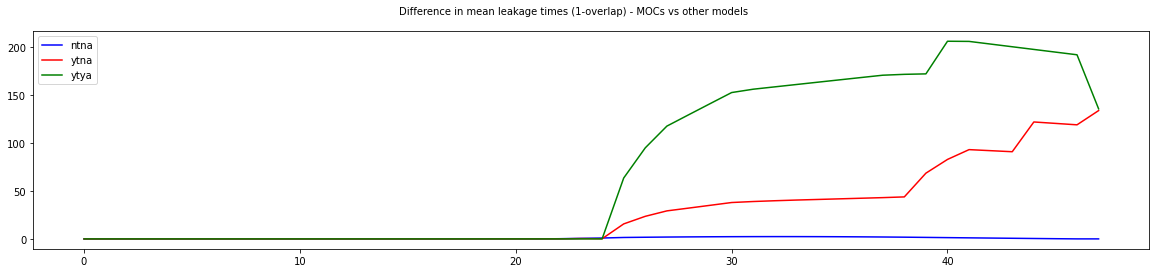

In [30]:
def make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle):
    matrixdim=data_ntna.ndim
    if matrixdim==1:                                                                              # single trace
        numloops=1
        xplot=np.shape(data_ntna)[0]
    else:                                                                                         # trace for each model run
        numloops=np.shape(data_ntna)[0]
        xplot=np.shape(data_ntna)[1]
    for t in np.arange(3):                                                                        # one plot for each steady state condition
        for i in np.arange(numloops):
            if matrixdim==1:
                if t==0:                                                                          # label x axis to identify steady state condition
                    c = ax1.plot(np.arange(xplot),data_ntna,color='blue',label='ntna')            # plot contours for all rows & columns in layer 1
                elif t==1:
                    c = ax1.plot(np.arange(xplot),data_ytna,color='red',label='ytna')             # plot contours for all rows & columns in layer 1
                    plt.figtext(0.5, 0.95, plottitle, ha='center', va='center')
                else:
                    c = ax1.plot(np.arange(xplot),data_ytya,color='green',label='ytya')           # plot contours for all rows & columns in layer 1
                    ax1.legend()
            else:
                if t==0:                                                                          # label x axis to identify steady state condition
                    c = ax1[t].plot(np.arange(xplot),data_ntna[i])                                # plot contours for all rows & columns in layer 1
                    ax1[t].set_xlabel('ntna')
                elif t==1:
                    c = ax1[t].plot(np.arange(xplot),data_ytna[i])                                # plot contours for all rows & columns in layer 1
                    ax1[t].set_xlabel('ytna')
                    plt.figtext(0.5, 0.95, plottitle, ha='center', va='center')
                else:
                    c = ax1[t].plot(np.arange(xplot),data_ytya[i])                                # plot contours for all rows & columns in layer 1
                    ax1[t].set_xlabel('ytya')                    
    
    
if run_sections>-1:
    plottitle='Streamflow along length of stream for every model'
    data_ntna=allflows_ss_ntna
    data_ytna=allflows_ss_ytna
    data_ytya=allflows_ss_ytya
    f10a,ax1 = plt.subplots(1,3,figsize=(20,4))           
    make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
    plt.show(f10a)                                                      

    plottitle='ML streamflow along length of stream'
    data_ntna=flowML_ss_ntna
    data_ytna=flowML_ss_ytna
    data_ytya=flowML_ss_ytya
    f10aa,ax1 = plt.subplots(1,1,figsize=(20,4))           
    make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
    plt.show(f10aa)                                                      

    plottitle='Mean streamflow along length of stream'
    data_ntna=flowmean_ss_ntna
    data_ytna=flowmean_ss_ytna
    data_ytya=flowmean_ss_ytya
    f10b,ax1 = plt.subplots(1,1,figsize=(20,4))           
    make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
    plt.show(f10b)                                                      

    plottitle='Standard deviation of streamflow along length of stream'
    data_ntna=flowvar_ss_ntna
    data_ytna=flowvar_ss_ytna
    data_ytya=flowvar_ss_ytya
    f10c,ax1 = plt.subplots(1,1,figsize=(20,4))           
    make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
    plt.show(f10c)                                                      

    plottitle='Leakage along length of stream for every model'
    data_ntna=allleaks_ss_ntna
    data_ytna=allleaks_ss_ytna
    data_ytya=allleaks_ss_ytya
    f11a,ax1 = plt.subplots(1,3,figsize=(20,4))           
    make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
    plt.show(f11a)                                                      

    plottitle='Mean leakage along length of stream'
    data_ntna=leakmean_ss_ntna
    data_ytna=leakmean_ss_ytna
    data_ytya=leakmean_ss_ytya
    f11b,ax1 = plt.subplots(1,1,figsize=(20,4))           
    make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
    plt.show(f11b)                                                      

    plottitle='Standard deviation of leakage along length of stream'
    data_ntna=leakvar_ss_ntna
    data_ytna=leakvar_ss_ytna
    data_ytya=leakvar_ss_ytya
    f11c,ax1 = plt.subplots(1,1,figsize=(20,4))           
    make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
    plt.show(f11c)                                                      

if run_sections>0:
    if np.shape(moc_ids_counter)[0] > 0:

        plottitle='Mean flow along length of stream - MOCs'
        data_ntna=moc_flowmean_ss_ntna
        data_ytna=moc_flowmean_ss_ytna
        data_ytya=moc_flowmean_ss_ytya
        f12a,ax1 = plt.subplots(1,1,figsize=(20,4))           
        make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
        plt.show(f12a)                                                      

        plottitle='Standard deviation of flow along length of stream - MOCs'
        data_ntna=moc_flowvar_ss_ntna
        data_ytna=moc_flowvar_ss_ytna
        data_ytya=moc_flowvar_ss_ytya
        f12b,ax1 = plt.subplots(1,1,figsize=(20,4))           
        make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
        plt.show(f12b)                                                      

        plottitle='Mean flow along length of stream - other models'
        data_ntna=other_flowmean_ss_ntna
        data_ytna=other_flowmean_ss_ytna
        data_ytya=other_flowmean_ss_ytya
        f12c,ax1 = plt.subplots(1,1,figsize=(20,4))           
        make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
        plt.show(f12c)                                                      

        plottitle='Standard deviation of flow along length of stream - other models'
        data_ntna=other_flowvar_ss_ntna
        data_ytna=other_flowvar_ss_ytna
        data_ytya=other_flowvar_ss_ytya
        f12d,ax1 = plt.subplots(1,1,figsize=(20,4))           
        make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
        plt.show(f12d)                                                      

if run_sections>1:
    if np.shape(moc_ids_counter)[0] > 0:
        plottitle='Difference in mean flow - MOCs vs other models'
        data_ntna=np.abs(moc_flowmean_ss_ntna-other_flowmean_ss_ntna)
        data_ytna=np.abs(moc_flowmean_ss_ytna-other_flowmean_ss_ytna)
        data_ytya=np.abs(moc_flowmean_ss_ytya-other_flowmean_ss_ytya)
        f13a,ax1 = plt.subplots(1,1,figsize=(20,4))           
        make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
        plt.show(f13a)                                                      

        plottitle='Sum of standard deviations of flow - MOCs vs other models'
        data_ntna=np.abs(moc_flowvar_ss_ntna+other_flowvar_ss_ntna)
        data_ytna=np.abs(moc_flowvar_ss_ytna+other_flowvar_ss_ytna)
        data_ytya=np.abs(moc_flowvar_ss_ytya+other_flowvar_ss_ytya)
        f13b,ax1 = plt.subplots(1,1,figsize=(20,4))           
        make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
        plt.show(f13b)                                                      

        plottitle='Difference in mean flow divided by sum of st devs - MOCs vs other models'
        tempvar=np.abs(moc_flowvar_ss_ntna+other_flowvar_ss_ntna)
        data_ntna=np.abs(moc_flowmean_ss_ntna-other_flowmean_ss_ntna)/tempvar
        tempvar=np.abs(moc_flowvar_ss_ytna+other_flowvar_ss_ytna)
        data_ytna=np.abs(moc_flowmean_ss_ytna-other_flowmean_ss_ytna)/tempvar
        tempvar=np.abs(moc_flowvar_ss_ytya+other_flowvar_ss_ytya)
        data_ytya=np.abs(moc_flowmean_ss_ytya-other_flowmean_ss_ytya)/tempvar
        f13c,ax1 = plt.subplots(1,1,figsize=(20,4))           
        make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
        plt.show(f13c)                                                      

        plottitle='Degree of overlap of flow - MOCs vs other models'
        data_ntna=overlap_ntna_flow
        data_ytna=overlap_ytna_flow
        data_ytya=overlap_ytya_flow
        f13d,ax1 = plt.subplots(1,1,figsize=(20,4))           
        make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
        plt.show(f13d)                                                      

        plottitle='Difference in mean flow times (1-overlap) - MOCs vs other models'
        data_ntna=np.abs(moc_flowmean_ss_ntna-other_flowmean_ss_ntna)*(1-overlap_ntna_flow)
        data_ytna=np.abs(moc_flowmean_ss_ytna-other_flowmean_ss_ytna)*(1-overlap_ytna_flow)
        data_ytya=np.abs(moc_flowmean_ss_ytya-other_flowmean_ss_ytya)*(1-overlap_ytya_flow)
        f13e,ax1 = plt.subplots(1,1,figsize=(20,4))           
        make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
        plt.show(f13e)                                                      

if run_sections>0:
    if np.shape(moc_ids_counter)[0] > 0:
        plottitle='Mean leakage along length of stream - MOCs'
        data_ntna=moc_leakmean_ss_ntna
        data_ytna=moc_leakmean_ss_ytna
        data_ytya=moc_leakmean_ss_ytya
        f14a,ax1 = plt.subplots(1,1,figsize=(20,4))           
        make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
        plt.show(f14a)                                                      

        plottitle='Standard deviation of leakage along length of stream - MOCs'
        data_ntna=moc_leakvar_ss_ntna
        data_ytna=moc_leakvar_ss_ytna
        data_ytya=moc_leakvar_ss_ytya
        f14b,ax1 = plt.subplots(1,1,figsize=(20,4))           
        make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
        plt.show(f14b)                                                      

        plottitle='Mean leakage along length of stream - other models'
        data_ntna=other_leakmean_ss_ntna
        data_ytna=other_leakmean_ss_ytna
        data_ytya=other_leakmean_ss_ytya
        f14c,ax1 = plt.subplots(1,1,figsize=(20,4))           
        make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
        plt.show(f14c)                                                      

        plottitle='Standard deviation of leakage along length of stream - other models'
        data_ntna=other_leakvar_ss_ntna
        data_ytna=other_leakvar_ss_ytna
        data_ytya=other_leakvar_ss_ytya
        f14d,ax1 = plt.subplots(1,1,figsize=(20,4))           
        make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
        plt.show(f14d)                                                      

if run_sections>1:
    if np.shape(moc_ids_counter)[0] > 0:
        plottitle='Difference in mean leakage - MOCs vs other models'
        data_ntna=np.abs(moc_leakmean_ss_ntna-other_leakmean_ss_ntna)
        data_ytna=np.abs(moc_leakmean_ss_ytna-other_leakmean_ss_ytna)
        data_ytya=np.abs(moc_leakmean_ss_ytya-other_leakmean_ss_ytya)
        f15a,ax1 = plt.subplots(1,1,figsize=(20,4))           
        make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
        plt.show(f15a)                                                      

        plottitle='Sum of standard deviations of leakage - MOCs vs other models'
        data_ntna=np.abs(moc_leakvar_ss_ntna+other_leakvar_ss_ntna)
        data_ytna=np.abs(moc_leakvar_ss_ytna+other_leakvar_ss_ytna)
        data_ytya=np.abs(moc_leakvar_ss_ytya+other_leakvar_ss_ytya)
        f15b,ax1 = plt.subplots(1,1,figsize=(20,4))           
        make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
        plt.show(f15b)                                                      

# THIS ISN'T WORKING RIGHT NOW ... NOT SURE WHY
#     plottitle='Difference in mean leakage divided by sum of st devs - MOCs vs other models'
#     temvpar=np.abs(moc_leakvar_ss_ntna+other_leakvar_ss_ntna)
#     data_ntna=np.abs(moc_leakmean_ss_ntna-other_leakmean_ss_ntna)/tempvar
#     temvpar=np.abs(moc_leakvar_ss_ytna+other_leakvar_ss_ytna)
#     data_ytna=np.abs(moc_leakmean_ss_ytna-other_leakmean_ss_ytna)/tempvar
#     temvpar=np.abs(moc_leakvar_ss_ytya+other_leakvar_ss_ytya)
#     data_ytya=np.abs(moc_leakmean_ss_ytya-other_leakmean_ss_ytya)/tempvar
#     f15,ax1 = plt.subplots(1,1,figsize=(20,4))           
#     make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
#     plt.show(f15)                                                      

if run_sections>2:
    if np.shape(moc_ids_counter)[0] > 0:
        plottitle='Degree of overlap of leakage - MOCs vs other models'
        data_ntna=overlap_ntna_flow
        data_ytna=overlap_ytna_flow
        data_ytya=overlap_ytya_flow
        f9a,ax1 = plt.subplots(1,1,figsize=(20,4))           
        make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
        plt.show(f9a)                                                      

        plottitle='Difference in mean leakage times (1-overlap) - MOCs vs other models'
        data_ntna=np.abs(moc_flowmean_ss_ntna-other_flowmean_ss_ntna)*(1-overlap_ntna_flow)
        data_ytna=np.abs(moc_flowmean_ss_ytna-other_flowmean_ss_ytna)*(1-overlap_ytna_flow)
        data_ytya=np.abs(moc_flowmean_ss_ytya-other_flowmean_ss_ytya)*(1-overlap_ytya_flow)
        f9b,ax1 = plt.subplots(1,1,figsize=(20,4))           
        make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
        plt.show(f9b)                                                      

if run_sections>2:
    del tempvar

**GENERATE HISTOGRAMS AT SELECTED LOCATIONS**
   

Locations of observation points, wells, and return flow


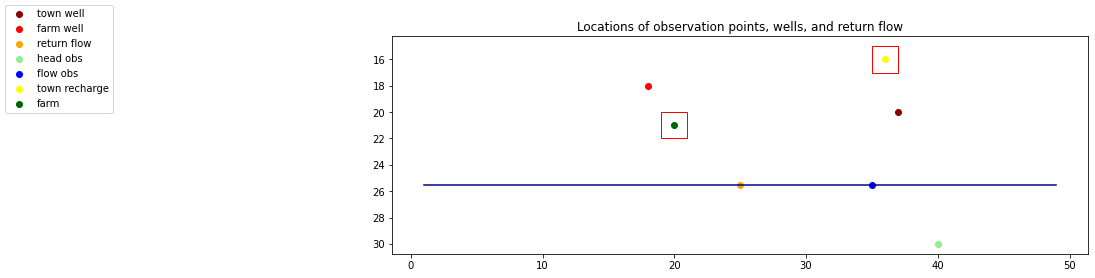

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


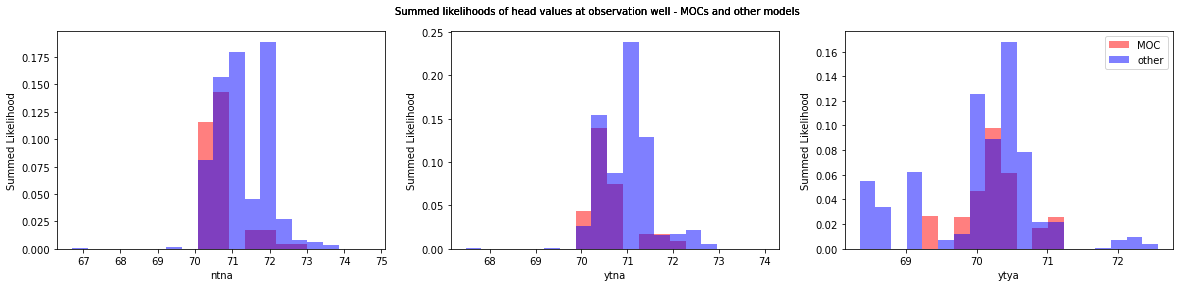

In [31]:
print('Locations of observation points, wells, and return flow')
f16,ax1 = plt.subplots(1,1,figsize=(20,4))                                                         # create & return figure & axes at position (row, col) of size 20x12 inches
extent = (0, ncol, 0, nrow)                                                                        # sets plot boundaries (x0,x1,y0,y1)
ax1.invert_yaxis()                                                                                 # reverses y axis direction so that row 0 is at the top
ax1.set_aspect(aspect='equal')
w1=ax1.scatter(well1[2], well1[1], c='DarkRed')                                                    # plot town well location (col = x, row = y)
w2=ax1.scatter(well2[2], well2[1], c='Red')                                                        # plot irrigation well location (col = x, row = y)
hobs=ax1.scatter(displaycolumn, displayrow, c='LightGreen')                                        # plot selected head location 
strobs=ax1.scatter(strdisplaycolumn, 25.5, c='Blue')                                               # plot selected stream flow location 
townret=ax1.scatter(return_loc, 25.5, c='Orange')                                                  # plot town return to stream 
ax1.plot(str_cols, str_rows+.5, c='DarkBlue')                                                      # plot stream location (col = x, row = y)
townrect = patches.Rectangle((rNWc[2],rNWc[1]),2,2,linewidth=1,edgecolor='Red',facecolor='none')
townmidx = rNWc[2]+1
townmidy = rNWc[1]+1
town_rech=ax1.scatter(townmidx, townmidy, c='Yellow')                                                                # plot town well location (col = x, row = y)
ax1.add_patch(townrect)                                                                            # plots town irrigation area
farmrect = patches.Rectangle((fNWc[1],fNWc[0]),2,2,linewidth=1,edgecolor='Red',facecolor='none')
agmidx = fNWc[1]+1
agmidy = fNWc[0]+1
ag_rech=ax1.scatter(agmidx, agmidy, c='DarkGreen')                                                 # plot town well location (col = x, row = y)
ax1.add_patch(farmrect)                                                                            # plots farm irrigation area
f16.legend([w1,w2,townret,hobs,strobs,town_rech,ag_rech],['town well','farm well','return flow',
     'head obs','flow obs','town recharge','farm'],loc=2)                                          # add legend center right
plt.title('Locations of observation points, wells, and return flow')
plt.show(f16)                                                                                      # display plot (not always necessary)

def plot_single_histograms(data_ntna,data_ytna,data_ytya,displayrow,displaycolumn,plottitle):
    matrixdim=data_ntna.ndim
    for j in np.arange(3):                                                                         # create plot for each steady state condition
        tempvals=[]
        tempws=[]
        for i in np.arange(np.shape(data_ntna)[0]):
            if matrixdim==2:
                if j==0:
                    addval=data_ntna[i][displaycolumn]
                    addweight=L[i]
                elif j==1:
                    addval=data_ytna[i][displaycolumn]
                    addweight=L[i]
                else:
                    addval=data_ytya[i][displaycolumn]
                    addweight=L[i]
            else:
                if j==0:
                    addval=data_ntna[i][displayrow][displaycolumn]
                    addweight=L[i]
                elif j==1:
                    addval=data_ytna[i][displayrow][displaycolumn]
                    addweight=L[i]
                else:
                    addval=data_ytya[i][displayrow][displaycolumn]
                    addweight=L[i]
            tempvals.append(addval)
            tempws.append(addweight)
        c = ax1[j].hist(tempvals,weights=tempws)                                                  # plots histogram of head in layer 1 across all models
        if j==0:                                                                                  # label x axis to identify steady state condition
            ax1[j].set_xlabel('ntna')
        elif j==1:
            ax1[j].set_xlabel('ytna')
            plt.figtext(0.5, 0.95, plottitle, ha='center', va='center')
        else:
            ax1[j].set_xlabel('ytya')
        ax1[j].set_ylabel('Summed Likelihood')

def plot_double_histograms(data_ntna,data_ytna,data_ytya,moc_ids_counter,other_ids_counter,
     displayrow,displaycolumn,plottitle):
    matrixdim=data_ntna.ndim
    
    for j in np.arange(3):    
        tempvals=[]
        tempws=[]
        for i in moc_ids_counter:                                                                 # plot drawdown due to ag at steady state
            if matrixdim==2:
                if j==0:
                    addval=data_ntna[i][displaycolumn]
                    addweight=L[i]
                elif j==1:
                    addval=data_ytna[i][displaycolumn]
                    addweight=L[i]
                else:
                    addval=data_ytya[i][displaycolumn]
                    addweight=L[i]
            else:
                if j==0:
                    addval=data_ntna[i][displayrow][displaycolumn]
                    addweight=L[i]
                elif j==1:
                    addval=data_ytna[i][displayrow][displaycolumn]
                    addweight=L[i]
                else:
                    addval=data_ytya[i][displayrow][displaycolumn]
                    addweight=L[i]
            if addval>0:
                tempvals.append(addval)
                tempws.append(addweight)
        tempvals2=[]
        tempws2=[]
        for i in other_ids_counter:                                                               # plot drawdown due to ag at steady state
            if matrixdim==2:
                if j==0:
                    addval=data_ntna[i][displaycolumn]
                    addweight=L[i]
                elif j==1:
                    addval=data_ytna[i][displaycolumn]
                    addweight=L[i]
                else:
                    addval=data_ytya[i][displaycolumn]
                    addweight=L[i]
            else:
                if j==0:
                    addval=data_ntna[i][displayrow][displaycolumn]
                    addweight=L[i]
                elif j==1:
                    addval=data_ytna[i][displayrow][displaycolumn]
                    addweight=L[i]
                else:
                    addval=data_ytya[i][displayrow][displaycolumn]
                    addweight=L[i]
            if addval>0:
                tempvals2.append(addval)
                tempws2.append(addweight)

        minval=min(np.min(tempvals),np.min(tempvals2))
        maxval=max(np.max(tempvals),np.max(tempvals2))        
        bins=minval+np.arange(20)*(maxval-minval)/20

        c = ax1[j].hist(tempvals,weights=tempws,bins=bins,alpha=0.5,color='red',label='MOC')                # plot contours for all rows & columns in layer 1
        c = ax1[j].hist(tempvals2,weights=tempws2,bins=bins,alpha=0.5,color='blue',label='other')             # plots contours for all rows & columns in layer 1
        if j==0:
            ax1[j].set_xlabel('ntna')
        elif j==1:
            ax1[j].set_xlabel('ytna')
        else:
            ax1[j].set_xlabel('ytya')        
        ax1[j].set_ylabel('Summed Likelihood')
        plt.legend(loc='upper right')
        plt.figtext(0.5, 0.95, plottitle, ha='center', va='center')
        

if run_sections>0:
    plottitle='Summed likelihoods of head values at observation well - MOCs and other models'
    data_ntna=allheads_ss_ntna
    data_ytna=allheads_ss_ytna
    data_ytya=allheads_ss_ytya
    f17,ax1 = plt.subplots(1,3,figsize=(20,4))                                                         # create & return figure & axes at position (row, col) of size 20x12 inches
    plot_double_histograms(data_ntna,data_ytna,data_ytya,moc_ids_counter,other_ids_counter,
         displayrow,displaycolumn,plottitle)
    plt.show(f17)

#     plottitle='Summed likelihoods of drawdown due to ag at observation point - MOCs and other models'
#     data_ntna=np.random.rand(np.shape(allheads_ss_ytna)[0],np.shape(allheads_ss_ytna)[1],
#          np.shape(allheads_ss_ytna)[2])*0
#     data_ytna=np.random.rand(np.shape(allheads_ss_ytna)[0],np.shape(allheads_ss_ytna)[1],
#          np.shape(allheads_ss_ytna)[2])*0
#     data_ytya=allheads_ss_ytna-allheads_ss_ytya
#     f18,ax1 = plt.subplots(1,3,figsize=(20,4))                                                        # create & return figure & axes at position (row, col) of size 20x12 inches
#     plot_double_histograms(data_ntna,data_ytna,data_ytya,moc_ids_counter,other_ids_counter,
#          displayrow,displaycolumn,plottitle)
#     plt.show(f18)                                                                                                                 # display plot (not always necessary)

#     plottitle='Summed likelihoods of flow values at observation cell - MOCs and other models'
#     data_ntna=allflows_ss_ntna
#     data_ytna=allflows_ss_ytna
#     data_ytya=allflows_ss_ytya
#     f19,ax1 = plt.subplots(1,3,figsize=(20,4))                                                        # create & return figure & axes at position (row, col) of size 20x12 inches
#     plot_double_histograms(data_ntna,data_ytna,data_ytya,moc_ids_counter,other_ids_counter,
#          displayrow,strdisplaycolumn,plottitle)
#     plt.show(f19)                                                                                                                 # display plot (not always necessary)

#     if 'discindex_overlap' in locals():
#         plottitle='Normalized discriminatory index'
#         f20,ax1 = plt.subplots(1,1,figsize=(20,4))                                                    # create & return figure & axes at position (row, col) of size 20x12 inches
#         data_ytna=-1*np.sort(-discindex_overlap)
#         data_ytna[np.isnan(data_ytna)]=0
#         data_ytna=np.reshape(data_ytna, np.shape(data_ytna)[0]*np.shape(data_ytna)[1])
#         data_ytna=-np.sort(-data_ytna)
#         data_ytna=data_ytna/data_ytna[0]
#         c = ax1.plot(np.arange(np.shape(data_ytna)[0]),data_ytna,color="blue",label='overlap') 
#         data_ytna=-1*np.sort(-discindex_std)
#         data_ytna[np.isnan(data_ytna)]=0
#         data_ytna=np.reshape(data_ytna, np.shape(data_ytna)[0]*np.shape(data_ytna)[1])
#         data_ytna=-np.sort(-data_ytna)
#         data_ytna=data_ytna/data_ytna[0]
#         c = ax1.plot(np.arange(np.shape(data_ytna)[0]),data_ytna,color="red",label='st-dev') 
#         ax1.set_xlabel('sorted possible measurement locations')
#         ax1.set_ylabel('normalized discriminatory index')
#         plt.legend()
#         plt.show(f20)

elif run_sections>-1 and len(runnumbers)>1:
    plottitle='Summed likelihoods of head values at observation well'
    data_ntna=allheads_ss_ntna
    data_ytna=allheads_ss_ytna
    data_ytya=allheads_ss_ytya
    f17,ax1 = plt.subplots(1,3,figsize=(20,4))                                                        # create & return figure & axes at position (row, col) of size 20x12 inches
    plot_single_histograms(data_ntna,data_ytna,data_ytya,displayrow,displaycolumn,plottitle)
    plt.show(f17)                                                                                     # display plot (not always necessary)plt.show(f9)                                                         # display plot (not always necessary)

    plottitle='Summed likelihoods of drawdown due to ag  at observation well'
    data_ntna=np.random.rand(np.shape(allheads_ss_ytna)[0],np.shape(allheads_ss_ytna)[1],
         np.shape(allheads_ss_ytna)[2])*0
    data_ytna=np.random.rand(np.shape(allheads_ss_ytna)[0],np.shape(allheads_ss_ytna)[1],
         np.shape(allheads_ss_ytna)[2])*0
    data_ytya=allheads_ss_ytna-allheads_ss_ytya
    f18,ax1 = plt.subplots(1,3,figsize=(20,4))                                                        # create & return figure & axes at position (row, col) of size 20x12 inches
    plot_single_histograms(data_ntna,data_ytna,data_ytya,displayrow,displaycolumn,plottitle)
    plt.show(f18)                                                                                     # display plot (not always necessary)plt.show(f9)                                                         # display plot (not always necessary)

    plottitle='Summed likelihoods of flow values at observation cell'
    data_ntna=allflows_ss_ntna
    data_ytna=allflows_ss_ytna
    data_ytya=allflows_ss_ytya
    f19,ax1 = plt.subplots(1,3,figsize=(20,4))                                                        # create & return figure & axes at position (row, col) of size 20x12 inches
    plot_single_histograms(data_ntna,data_ytna,data_ytya,displayrow,strdisplaycolumn,plottitle)
    plt.show(f19)                                                                                     # display plot (not always necessary)plt.show(f9)                                                         # display plot (not always necessary)

    del data_ntna                                                                                     # clear temporary variables
    del data_ytna
    del data_ytya
    del w1
    del w2
    del hobs
    del strobs
    del townret
    del townrect
    del townmidx
    del townmidy
    del town_rech
    del farmrect
    del agmidx
    del agmidy
    del ag_rech
    del plottitle


**Save figures**

In [50]:
if run_sections>0:
    figure_directory()

    figures = [f0,f1,f2,f3aa,f3a,f3b,f4a,f4b,f5a,f5b,f6a,f6b,f6c,f6d,f6e,f7a,f7b,f8a,f8b,f8c,f9a,f9b,f10aa,f10a,f10b,f10c,f11a,f11b,f11c,f12a,f12b,f12c,f12d,f13a,f13b,f13c,f13d,f13e,f14a,f14b,f14c,f14d,f15a,f15b,f16,f17]   # list of figures
#     figures = [f0,f1,f2,f3aa,f3a,f3b,f4a,f4b,f5a,f5b,f6a,f6b,f6c,f6d,f6e,f7a,f7b,f8a,f8b,f8c,f9a,f9b,f10aa,f10a,f10b,f10c,f11a,f11b,f11c,f12a,f12b,f12c,f12d,f13a,f13b,f13c,f13d,f13e,f14a,f14b,f14c,f14d,f15a,f15b,f16,f17,f18,f19]   # list of figures
    fig_names = []                                                              # initialize empty list for figure names
    for i in range(len(figures)):                                               # loop over number of figures
        fig_names.append('f' + str(i) + '.png')                         # create figure names
        figures[i].savefig(fig_names[i])                                        # save figures as a .png files


**Retrieve head and flow data from the 'truth' model and the ML model**

In [32]:
stream_obsloc_col=35
head_obsloc=[20,37]

print(trueflows_ss_ytna[stream_obsloc_col][1])
print(allheads_ss_ytya[MLmodelID,head_obsloc[0],head_obsloc[1]])    
print(allheads_ss_ytna[MLmodelID,head_obsloc[0],head_obsloc[1]])    


154.95793
69.85309600830078
70.61329650878906


In [70]:
runnumbers[-55]

'm001001332024331'

In [76]:
comparison_directory()
sortedL_file = np.load("env_combine_sorted_L.npy")
runnumbers_file = np.load("env_combine_runnumbers.npy")

In [77]:
runnumbers_file

array(['m001001330022410', 'm001001330030142', 'm001001330030143',
       'm001001330041044', 'm001001330200120', 'm001001330202214',
       'm001001330212434', 'm001001330214440', 'm001001330231201',
       'm001001330240302', 'm001001330310043', 'm001001330321410',
       'm001001330340341', 'm001001330343330', 'm001001330344340',
       'm001001330401001', 'm001001330402000', 'm001001330414442',
       'm001001331011432', 'm001001331012122', 'm001001331012420',
       'm001001331014241', 'm001001331021131', 'm001001331021300',
       'm001001331100244', 'm001001331100430', 'm001001331101111',
       'm001001331101140', 'm001001331110101', 'm001001331112303',
       'm001001331130223', 'm001001331144431', 'm001001331202232',
       'm001001331232114', 'm001001331311000', 'm001001331331003',
       'm001001331332234', 'm001001331334210', 'm001001331340213',
       'm001001331421032', 'm001001331430200', 'm001001331430314',
       'm001001332014344', 'm001001332021121', 'm0010013320232